In [ ]:
from IPython.display import display, HTML

display(HTML('''
<div style="display: flex; justify-content: center; align-items: center; text-align: center;">
    <img alt="udeA logo" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width: 107px; height: 152px; margin-right: 20px;">
    <div>
        <h2 style="font-size: 28px;"><strong>Proyecto 4: Clasificación de Señales ECG</strong></h2>
        <p>Sergio Daza Vasquez - 1010082612</p>
        <p>Natalia Arenas Pachón - 1007729698</p>
        <p>Daniel Barrera Mazo - 1045439175</p>
    </div>
</div>
'''))

In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 13.4 MB/s eta 0:00:00


In [ ]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.5 MB/s eta 0:00:00


In [ ]:
# Librerias a usar a lo largo de la practica
import neurokit2 as nk
import pywt
import csv
import seaborn as sns
import matplotlib.pyplot as plt;
import numpy as np;
import scipy.io as sio;
import os
from google.colab import drive
import pandas as pd
from scipy.stats import shapiro , levene, mannwhitneyu
from scipy.stats import kstest, norm
from scipy.signal import detrend
from scipy import fft
import scipy.signal as signal
from scipy.fft import fftfreq
import csv
from statsmodels.robust import mad
import pylab
import statsmodels.api as sm
import random
from scipy.signal import detrend
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.signal.windows import hann

drive.mount('/content/drive')

Mounted at /content/drive


### **1.** Revisión teórica. Del artículo: https://www.nature.com/articles/s41598-020-59821-7

Hacer un resumen de la sección extracción de caracteríticas (Features extraction) y discutir desde el artículo u otras referencias como se hace cuando desaparecen ciertas formas de ondas en el complejo PQRS debido a alguna enfermedad.

<blockquote>
<p> → En el artículo se describe un método patentado para la extracción de características aplicado a señales de ECG, diseñado para obtener información detallada y relevante para la clasificación precisa de arritmias. Este método de extracción de características se fundamenta en el uso de percentiles de la distribución empírica de proporciones de longitudes de intervalos y magnitudes de picos y valles, lo que permite representar relaciones complejas entre las características de las ondas P, QRS y T, así como entre los segmentos PR, QT y RR. Además, integra un clasificador de Árbol de Refuerzo de Gradiente Extremo (EGBT) para optimizar la precisión de los modelos predictivos.<br></p>

<p>Se evaluaron 11 grupos de características, desde un conjunto básico de 11 variables (como duración del QRS, intervalos QT y RR, ritmo ventricular y auricular) hasta un grupo más amplio que incluye 39.830 características, obtenido mediante la combinación de dos grupos de características que incluyen características como altura, anchura, prominencia y localización relativa de los picos y valles. <br></p>

<p>Además, en el artículo incluyeron variables demográficas, como edad y género, debido a su relevancia clínica en la variabilidad de los ECG. Con el fin de reducir las diferencias individuales, como las relacionadas con género, edad o raza, debido a ECG diferentes tanto en amplitud como en frecuencia, el método normalizó las amplitudes de las señales. Finalmente, se realizó un  análisis  adicional  que  se  centró  en  la  selección  óptima  de   hiperparámetros  mediante  una búsqueda en cuadrícula (grid search).</p>

<p> En cuanto a la desaparición de ciertas formas de onda en el complejo QRS, esto puede ocurrir debido a la distorsión presente en diversas condiciones patológicas. Por ejemplo, en la fibrilación auricular (AFIB) y el aleteo auricular (AFL), las ondas P pueden ser reemplazadas por múltiples ondas de fibrilación o aleteo, las cuales tienen una menor amplitud y no corresponden con el ritmo del complejo QRS. Esta distorsión en la morfología de las ondas puede complicar la identificación de patrones específicos y dificultar la clasificación precisa de las arritmias. Por ello, en el artículo se empleó un paso preliminar de manipulación de datos utilizando un algoritmo de máximo- mínimo para unificar la escala de amplitud, y que no afecten negativamente la capacidad del modelo para analizar y clasificar los ECG.</p>

<p>→ En diversos artículos se ha asociado la ausencia de ciertas ondas en el ECG con patologías específicas. Por ejemplo, T. Pander [1] destaca que la ausencia de ondas P es un indicador clave de fibrilación auricular (FA). Asimismo, en [3] se describe que el rasgo distintivo de la FA es la falta de ondas P y la presencia de una frecuencia ventricular irregular, además de una línea base caracterizada por ondas fibrilatorias (ondas f) o pequeñas oscilaciones. </p>
</blockquote>

### **2.** Base de datos

Del proyecto pasado hay dos opciones de base de datos, la filtrada por los autores o la filtrada en el proyecto 3. De acuerdo a los resultados del proyecto 3 usar la mejor base de datos y justificar la selección.

<blockquote>

**Base de datos seleccionada:** Filtrada por los autores.

**Justificación:** La eleccion de esta se sustenta en el analisis realizado durante el proyecto 3 en el cual se realizo una comparación entre los resultados del Proyecto 2 y el Proyecto 3, en el cual se evaluo una de las caracteristicas clave que usaremos en este proyecto 4 (la frecuencia de máxima potencia) en las condiciones de bradicardia sinusal (SB) y fibrilación auricular (AFIB).

En el Proyecto 3, se identifico que el uso del Periodograma de Welch y un flujo de filtrado menos restrictivo permitió capturar frecuencias de mayor rango, con medianas cercanas a los 10 Hz para ambas patologías, en contraste con el Proyecto 2, donde las medianas se concentraron alrededor de los 5 Hz. Aunque esta mayor sensibilidad en el Proyecto 3 permitió detectar componentes de alta frecuencia, también introdujo la posibilidad de capturar ruido, lo cual podría dificultar la interpretación clínica y el análisis diagnóstico, especialmente en señales complejas como AFIB.

Por otro lado, en el Proyecto 2 que utilizó un prefiltrado por parte de las autores y la Transformada de Fourier, priorizo frecuencias bajas que están más alineadas con las características fisiológicas típicas de las señales cardíacas, lo que puede ser particularmente ventajoso en aplicaciones clínicas al minimizar la interferencia y reducir la complejidad de las señales procesadas. Para señales como las de SB, que presentan menor dispersión y una naturaleza más estable, esta concentración en frecuencias bajas permite un análisis más robusto y menos propenso a errores inducidos por ruido.

En términos estadísticos, las diferencias significativas encontradas entre ambos proyectos refuerzan que el enfoque del Proyecto 3 capturó información adicional; sin embargo, la simplicidad y el prefiltrado del Proyecto 2 proporcionan una base más confiable y menos susceptible al ruido con captura de frecuencias alineadas a las caracteristicas fisiologicas, lo que resulta crucial para un modelo de clasificación basado en redes neuronales, donde señales más limpias pueden mejorar la capacidad del modelo para identificar patrones relevantes.
</blockquote>

> De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx De estos registros los análisis para el presente proyecto deben hacerse en la derivación II.

In [ ]:
archivo_excel = "/content/drive/MyDrive/Colab_Notebooks/Diagnostics.xlsx"

df = pd.read_excel(archivo_excel) # se carga el excel

#filas donde la columna 'Rhythm' sea 'SB' o 'AFIB'
filtros = df[df['Rhythm'].isin(['SB', 'AFIB'])]
filtros.head()


FileName Rhythm      Beat  PatientAge  Gender  \
0  MUSE_20180113_171327_27000   AFIB  RBBB TWC          85    MALE   
1  MUSE_20180112_073319_29000     SB       TWC          59  FEMALE   
3  MUSE_20180113_121940_44000     SB      NONE          66    MALE   
5  MUSE_20180112_120347_79000     SB      NONE          46  FEMALE   
6  MUSE_20180114_075026_69000   AFIB       TWC          80  FEMALE   

   VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  RAxis  \
0              117         234          114         356          496     81   
1               52          52           92         432          401     76   
3               53          53           96         456          427     34   
5               57          57           70         404          393     38   
6               98          86           74         360          459     69   

   TAxis  QRSCount  QOnset  QOffset  TOffset  
0    -27        19     208      265      386  
1     42         8     215      261      431  
3      3         9     219      267      447  
5     24         9     225      260      427  
6     83        17     215      252      395

In [ ]:
total_registros = filtros.shape[0]
print(f"Total de registros con SB y AFIB en la columna 'Rhythm': {total_registros}")

Total de registros con SB y AFIB en la columna 'Rhythm': 5669


In [ ]:
!cp /content/drive/MyDrive/Colab_Notebooks/ECGDataDenoised.zip .
!unzip -q ECGDataDenoised.zip

In [ ]:
directorio_actual=os.getcwd()
archivos = os.listdir(directorio_actual + "/ECGDataDenoised")
pacientes_filtrados = filtros['FileName'].tolist() # Lista de nombres de archivos de pacientes filtrado

#filtran los archivos que corresponden a los pacientes filtrados
archivos_filtrados = [archivo for archivo in archivos if archivo.split('.')[0] in pacientes_filtrados]

#listas separadas para SB y AFIB
archivos_SB = [archivo for archivo in archivos_filtrados if filtros[filtros['FileName'] == archivo.split('.')[0]]['Rhythm'].values[0] == 'SB']
archivos_AFIB = [archivo for archivo in archivos_filtrados if filtros[filtros['FileName'] == archivo.split('.')[0]]['Rhythm'].values[0] == 'AFIB']

print(f"Se encontraron {len(archivos_SB)} archivos correspondientes a los pacientes con SB.")
print(f"Se encontraron {len(archivos_AFIB)} archivos correspondientes a los pacientes con AFIB.")

Se encontraron 3889 archivos correspondientes a los pacientes con SB.
Se encontraron 1780 archivos correspondientes a los pacientes con AFIB.


In [ ]:
column_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ruta_base = os.path.join(directorio_actual, "ECGDataDenoised")

def cargar_ecg(ruta_base, archivo, column_names):
    ruta_archivo = os.path.join(ruta_base, archivo)
    df_ecg = pd.read_csv(ruta_archivo, names=column_names)
    return df_ecg['II'].values  # Retornar los datos de la columna 'II'

> Se almacenan los datos asociados a la derivacion II en un diccionario. Esto para cada condicion (AFIB y SB)





In [ ]:
# Diccionario para almacenar los datos de la columna II de cada archivo AFIB
datos_ecg_afib = {}

# Se itera sobre cada archivo en la lista archivos_AFIB
for archivo in archivos_AFIB:
    # Se extraen los datos de la columna II y se almacenan en el diccionario
    datos_ecg_afib[archivo] = cargar_ecg(ruta_base, archivo, column_names)


In [ ]:
# Diccionario para almacenar los datos de la columna II de cada archivo SB
datos_ecg_sb_dict = {}

# Se itera sobre cada archivo en la lista archivos_SB
for archivo in archivos_SB:
    # Se extraen los datos de la columna II y se almacenan en el diccionario
    datos_ecg_sb_dict[archivo] = cargar_ecg(ruta_base, archivo, column_names)

> A partir del análisis del artículo de referencia [1], se concluye la necesidad de normalizar las amplitudes de las señales. Esto se debe a la importancia de ajustar las diferencias en amplitud entre señales patológicas. En este caso, como paso preliminar, se lleva a cabo la normalización y la eliminación de tendencias (detrend). Además, para garantizar la coherencia con los datos de frecuencia máxima del proyecto 2, se aplicará un proceso de detrend inicial, seguido de normalización y un segundo detrend para corregir cualquier offset introducido por el paso inmediatamente anterior, con el fin de unificar la escala de amplitud.

In [ ]:
def normalize_ecg(c_tk, x_min, x_max):
    return (c_tk - x_min) / (x_max - x_min)

In [ ]:
def preprocess(datos_ecg):
    datos_ecg_procesados = {}

    for registro, señal in datos_ecg.items():
            #detrend
            señal_detrend_1 = detrend(señal)

            #Compression
            x_min, x_max = señal_detrend_1.min(), señal_detrend_1.max()
            señal_normalizada = normalize_ecg(señal_detrend_1, x_min, x_max)

            #El detrend para eliminar el offset que genera compression
            señal_detrend_2 = detrend(señal_normalizada)

            # señal procesada en el nuevo diccionario
            datos_ecg_procesados[registro] = señal_detrend_2

    return datos_ecg_procesados

datos_ecg_afib_procesados = preprocess(datos_ecg_afib)
datos_ecg_sb_procesados = preprocess(datos_ecg_sb_dict)

# resultados
print(f"Señales procesadas para AFIB: {len(datos_ecg_afib_procesados)}")
print(f"Señales procesadas para SB: {len(datos_ecg_sb_procesados)}")

Señales procesadas para AFIB: 1780
Señales procesadas para SB: 3889


### **3.** Herramientas computacionales. Hacer un minitutorial del uso de la herramienta NeuroKit

> A continuación, en el siguiente enlace se encontrará el minitutorial del uso de la NeuroKit en colab:
[Tutorial NeuroKit](https://drive.google.com/file/d/1yKrI2PLXn7Ss74fG3teoamfKdcBYzS3f/view?usp=sharing)

### **4.** Escoger diferentes señales de la base de datos del punto 2 y aplicar el tutorial del punto 3

Para visualizar de manera adecuada la implementacion de la herramienta Neurokit y el tutorial, se decidio utilizar dos señales (una de SB y otra de AFIB), de esta manera evidenciar si se presentan diferencias en la ejecucion de cada registro aplicando NeuroKit

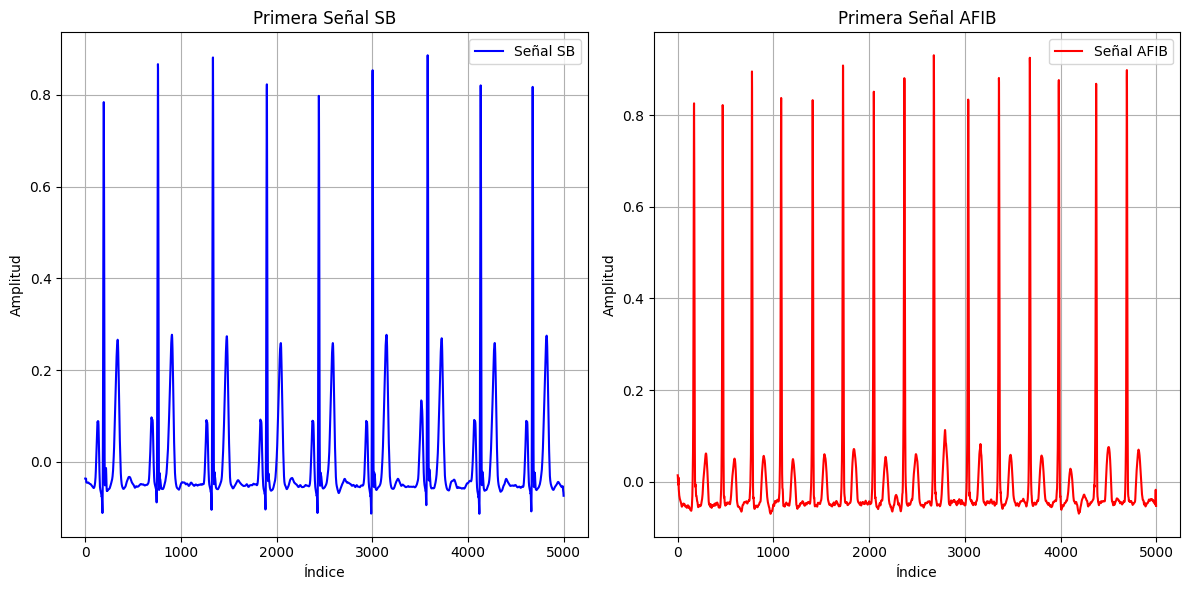

In [ ]:
primera_senal_sb = list(datos_ecg_sb_procesados.values())[0][1:].astype(float)
primera_senal_afib = list(datos_ecg_afib_procesados.values())[0][1:].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(primera_senal_sb, label='Señal SB', color='b')
axes[0].set_title('Primera Señal SB')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('Amplitud')
axes[0].grid()
axes[0].legend()
axes[1].plot(primera_senal_afib, label='Señal AFIB', color='r')
axes[1].set_title('Primera Señal AFIB')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Amplitud')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

> Se procesa la señal usando la función ecg_process ya que como se explico en el tutorial es una funcion muy completa que nos permite diferentes pasos de preprocesamiento: limpieza (usando ecg_clean()), detección de picos (usando ecg_peaks()), cálculo de frecuencia cardíaca (usando signal_rate()), evaluación de la calidad de la señal (usando ecg_quality()), delineación del complejo QRS (usando ecg_delineate()) y determinación de la fase cardíaca (usando ecg_phase()). y se obtienen la grafica gracias a la funcion ecg_plot del neurokit

ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0    -0.036658  -0.022904  53.559473     0.855174            0            0   
1    -0.036741  -0.023090  53.559473     0.855174            0            0   
2    -0.036840  -0.023351  53.559473     0.855174            0            0   
3    -0.036943  -0.023687  53.559473     0.855174            0            0   
4    -0.037028  -0.024097  53.559473     0.855174            0            0   
...        ...        ...        ...          ...          ...          ...   
4994 -0.064048   0.004557  55.248619     0.000000            0            0   
4995 -0.065000   0.003586  55.248619     0.000000            0            0   
4996 -0.066796   0.002473  55.248619     0.000000            0            0   
4997 -0.069915   0.001223  55.248619     0.000000            0            0   
4998 -0.074064  -0.000130  55.248619     0.000000            0            0   

      ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  ECG_R_Offsets  \
0                0              0            0             0              0   
1                0              0            0             0              0   
2                0              0            0             0              0   
3                0              0            0             0              0   
4                0              0            0             0              0   
...            ...            ...          ...           ...            ...   
4994             0              0            0             0              0   
4995             0              0            0             0              0   
4996             0              0            0             0              0   
4997             0              0            0             0              0   
4998             0              0            0             0              0   

      ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  ECG_Phase_Atrial  \
0               0            0             0              0               NaN   
1               0            0             0              0               NaN   
2               0            0             0              0               NaN   
3               0            0             0              0               NaN   
4               0            0             0              0               NaN   
...           ...          ...           ...            ...               ...   
4994            0            0             0              0               NaN   
4995            0            0             0              0               NaN   
4996            0            0             0              0               NaN   
4997            0            0             0              0               NaN   
4998            0            0             0              0               NaN   

      ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                             0.0                    NaN   
1                             0.0                    NaN   
2                             0.0                    NaN   
3                             0.0                    NaN   
4                             0.0                    NaN   
...                           ...                    ...   
4994                          0.0                    NaN   
4995                          0.0                    NaN   
4996                          0.0                    NaN   
4997                          0.0                    NaN   
4998                          0.0                    NaN   

      ECG_Phase_Completion_Ventricular  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0  
...                                ...  
4994                               0.0  
4995                               0.0  
4996                               0.0  
4997 

<Figure size 10000x30000 with 0 Axes>

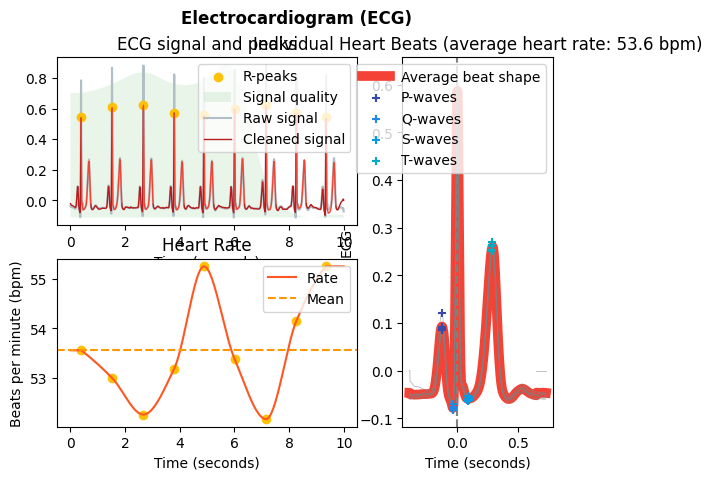

In [ ]:
señalSB, infoSB = nk.ecg_process(primera_senal_sb, sampling_rate=500)
# Graficar usando el DataFrame generado por ecg_process
plt.figure(figsize=(100, 300))
nk.ecg_plot(señalSB, infoSB)

señalSB

> Con el fin de visualizar la implementacion de las funciones del Neurokit, se graficó la señal con la implementacion de cada herramienta de NeuroKit

### **Aplicación en la señal SB**

➡ **Aplicacion de ecg_peaks**

Picos R detectados (muestras): [ 194  760 1334 1898 2441 3003 3578 4132 4675]


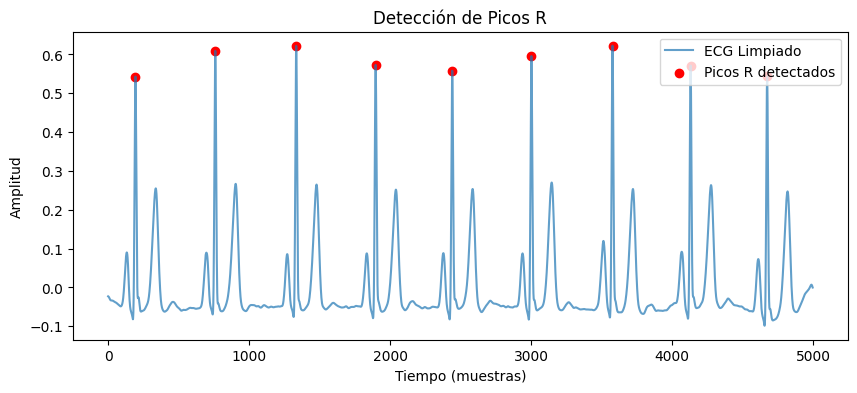

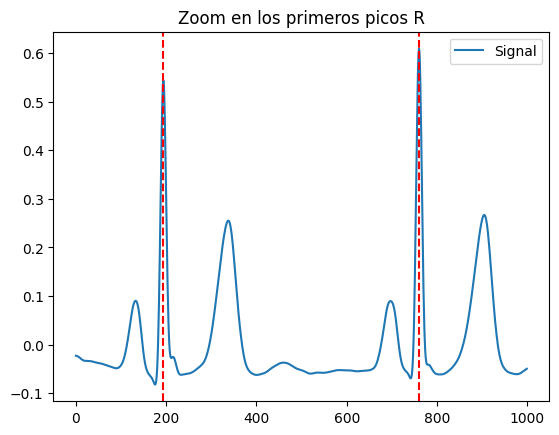

In [ ]:
ecg_cleanedSB = señalSB["ECG_Clean"]

r_peaks, info_peaks = nk.ecg_peaks(ecg_cleanedSB,sampling_rate=500,method="neurokit",correct_artifacts=False,show=False)

rpeaks_positions = info_peaks["ECG_R_Peaks"]
print("Picos R detectados (muestras):", info_peaks["ECG_R_Peaks"])

plt.figure(figsize=(10, 4))
plt.plot(ecg_cleanedSB, label="ECG Limpiado", alpha=0.7)
plt.scatter(info_peaks["ECG_R_Peaks"], ecg_cleanedSB[info_peaks["ECG_R_Peaks"]],
            color="red", label="Picos R detectados")
plt.title("Detección de Picos R")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()
plt.show()

# Acercamiento a los primeros 5 picos R
nk.events_plot(rpeaks_positions[:2], ecg_cleanedSB[:1000])
plt.title("Zoom en los primeros picos R")
plt.show()

➡ **Aplicación de ecg_delineate()**

<Figure size 2000x1000 with 0 Axes>

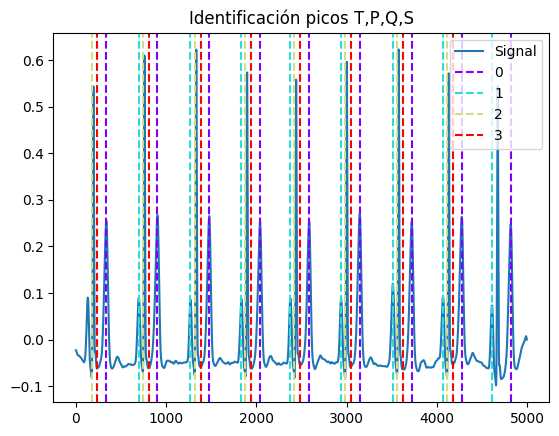

In [ ]:
# Delinear la señal de ECG para identificar ondas P, Q, S, y T
delimitar, delineate_info = nk.ecg_delineate(ecg_cleanedSB,rpeaks=rpeaks_positions,sampling_rate=500,method="dwt",show=False)

plt.figure(figsize=(20, 10))
# ondas (P, Q, R, S, T)
plot = nk.events_plot(
    [
        delineate_info["ECG_T_Peaks"][:10],  # Ondas T (limitado a las primeras 10)
        delineate_info["ECG_P_Peaks"][:10],  # Ondas P
        delineate_info["ECG_Q_Peaks"][:10],  # Ondas Q
        delineate_info["ECG_S_Peaks"][:10]   # Ondas S
    ],
    ecg_cleanedSB[:5000]  # Señal extendida hasta las primeras 5000 muestras
)

plt.title("Identificación picos T,P,Q,S")
plt.show()

➡ **Aplicación fase_ecg()**

In [ ]:
#función ecg_phase
ecg_phases = nk.ecg_phase(ecg_cleanedSB,rpeaks=rpeaks_positions,delineate_info=delineate_info,sampling_rate=500)


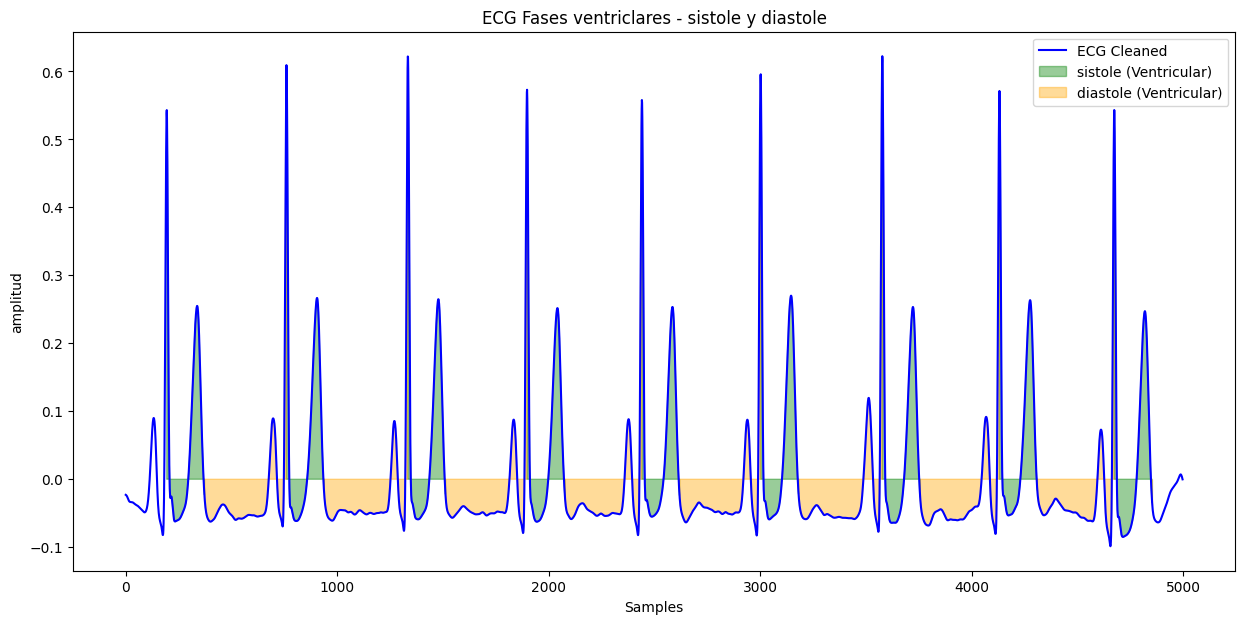

In [ ]:
# Obtener las fases ventriculares del ECG
ventricular_phase = ecg_phases["ECG_Phase_Ventricular"]

# Visualizar las fases del ECG
plt.figure(figsize=(15, 7))

# Graficar la señal limpia de ECG
plt.plot(ecg_cleanedSB[:5000], label="ECG Cleaned", color="blue")

# Graficar las fases ventriculares
plt.fill_between(
    range(len(ventricular_phase[:5000])),
    ecg_cleanedSB[:5000],
    where=(ventricular_phase[:5000] == 1),  # Sístole
    color="green",
    alpha=0.4,
    label="sistole (Ventricular)"
)
plt.fill_between(
    range(len(ventricular_phase[:5000])),
    ecg_cleanedSB[:5000],
    where=(ventricular_phase[:5000] == 0),  # Diástole
    color="orange",
    alpha=0.4,
    label="diastole (Ventricular)"
)

plt.title("ECG Fases ventriclares - sistole y diastole")
plt.xlabel("Samples")
plt.ylabel("amplitud")
plt.legend()
plt.show()


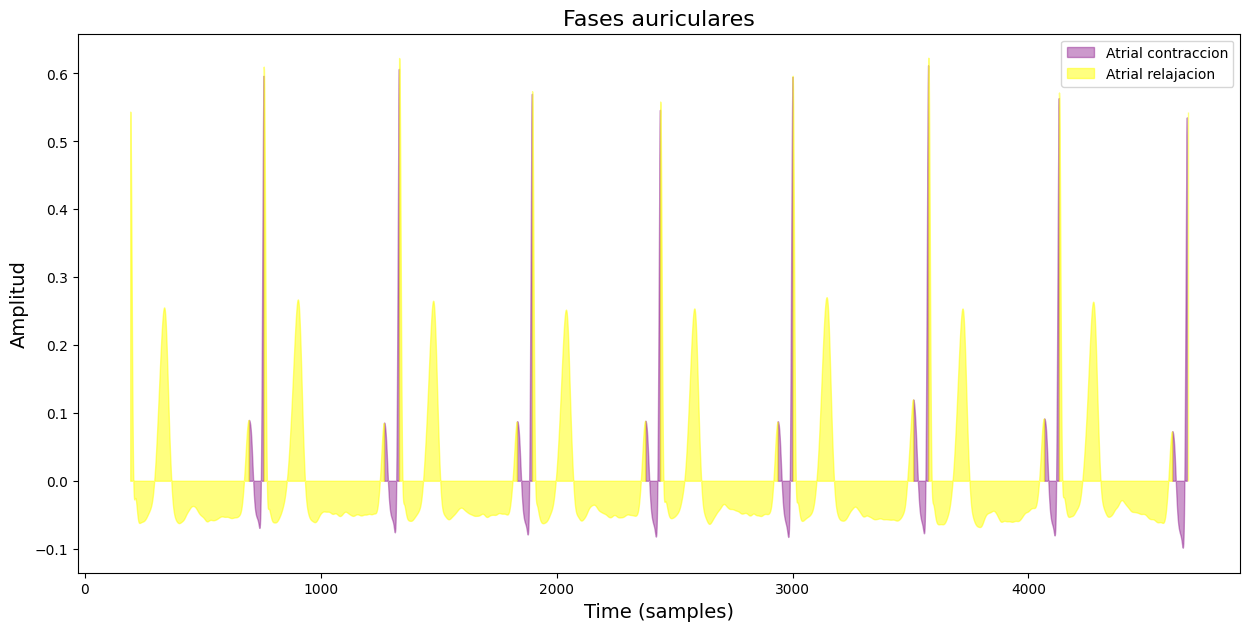

In [ ]:
atrial_phase = ecg_phases["ECG_Phase_Atrial"]
plt.figure(figsize=(15, 7))
plt.fill_between(
    range(len(atrial_phase[:5000])),
    ecg_cleanedSB[:5000],
    where=(atrial_phase[:5000] == 1),  # Contracción auricular
    color="purple",
    alpha=0.4,
    label="Atrial contraccion"
)
plt.fill_between(
    range(len(atrial_phase[:5000])),
    ecg_cleanedSB[:5000],
    where=(atrial_phase[:5000] == 0),  # Relajación auricular
    color="yellow",
    alpha=0.5,
    label="Atrial relajacion"
)

plt.legend()
plt.title("Fases auriculares", fontsize=16)
plt.xlabel("Time (samples)", fontsize=14)
plt.ylabel("Amplitud", fontsize=14)
plt.show()


➡ **Aplicación de análisis en el dominio del tiempo(HRV_Mean)**

> Esta función se aplica para obtener el dato HRV_MeanNN, que hace referencia a la variabilidad de la frecuencia cardiaca, más especificamente, la media de los intervalos RR.

In [ ]:
# Extract clean EDA and SCR features
hrv_time = nk.hrv_time(r_peaks, sampling_rate=500)
hrv_time

HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0     1120.25  24.967121         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  31.140236  32.87784  ...       33.5     0.801764   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0       1094.8       1141.6        0.0       62.5     1086.0     1150.0   

   HRV_HTI  HRV_TINN  
0      4.0       0.0  

[1 rows x 25 columns]

### **Aplicación en la señal AFIB**

ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0     0.014378  -0.010708  92.858722          0.0            0            0   
1     0.013116  -0.012941  92.858722          0.0            0            0   
2     0.009110  -0.015392  92.858722          0.0            0            0   
3     0.003116  -0.017976  92.858722          0.0            0            0   
4    -0.002763  -0.020546  92.858722          0.0            0            0   
...        ...        ...        ...          ...          ...          ...   
4994 -0.017157   0.015513  93.457944          0.0            0            0   
4995 -0.019817   0.013358  93.457944          0.0            0            0   
4996 -0.027624   0.010464  93.457944          0.0            0            0   
4997 -0.039165   0.007064  93.457944          0.0            0            0   
4998 -0.052401   0.003453  93.457944          0.0            0            0   

      ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  ECG_R_Offsets  \
0                0              0            0             0              0   
1                0              0            0             0              0   
2                0              0            0             0              0   
3                0              0            0             0              0   
4                0              0            0             0              0   
...            ...            ...          ...           ...            ...   
4994             0              0            0             0              0   
4995             0              0            0             0              0   
4996             0              0            0             0              0   
4997             0              0            0             0              0   
4998             0              0            0             0              0   

      ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  ECG_Phase_Atrial  \
0               0            0             0              0               NaN   
1               0            0             0              0               NaN   
2               0            0             0              0               NaN   
3               0            0             0              0               NaN   
4               0            0             0              0               NaN   
...           ...          ...           ...            ...               ...   
4994            0            0             0              0               NaN   
4995            0            0             0              0               NaN   
4996            0            0             0              0               NaN   
4997            0            0             0              0               NaN   
4998            0            0             0              0               NaN   

      ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                             0.0                    NaN   
1                             0.0                    NaN   
2                             0.0                    NaN   
3                             0.0                    NaN   
4                             0.0                    NaN   
...                           ...                    ...   
4994                          0.0                    NaN   
4995                          0.0                    NaN   
4996                          0.0                    NaN   
4997                          0.0                    NaN   
4998                          0.0                    NaN   

      ECG_Phase_Completion_Ventricular  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0  
...                                ...  
4994                               0.0  
4995                               0.0  
4996                               0.0  
4997 

<Figure size 2500x2000 with 0 Axes>

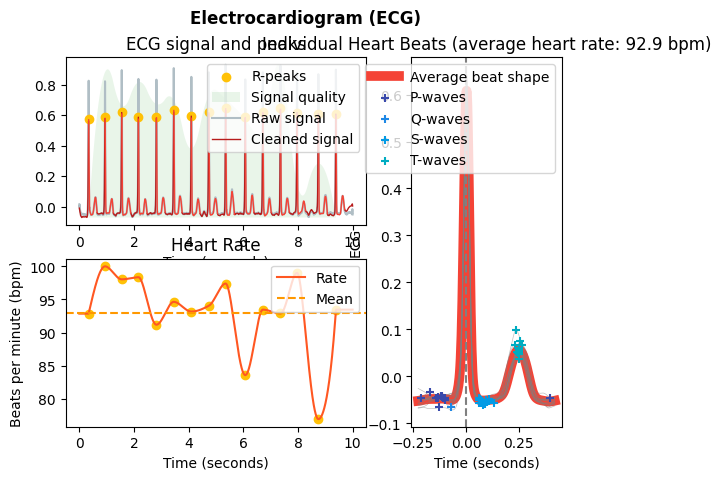

In [ ]:
señalAFIB, infoAFIB = nk.ecg_process(primera_senal_afib, sampling_rate=500)
# Graficar usando el DataFrame generado por ecg_process
plt.figure(figsize=(25, 20))
nk.ecg_plot(señalAFIB, infoAFIB)
señalAFIB

Picos R detectados (muestras): [ 170  470  776 1081 1410 1727 2049 2368 2676 3035 3356 3679 3982 4372
 4693]


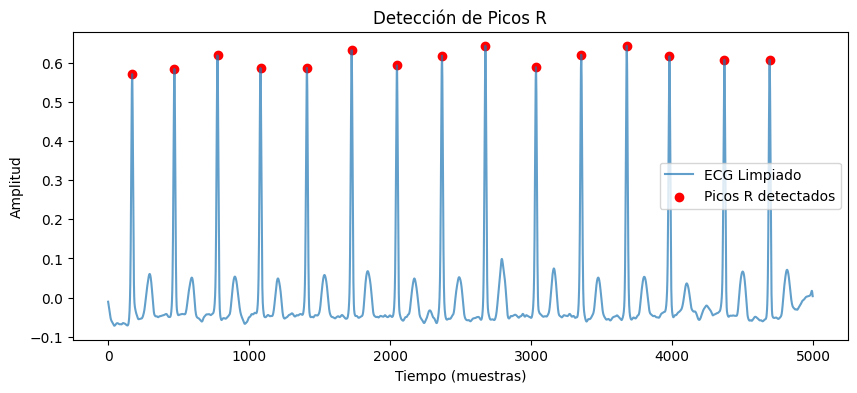

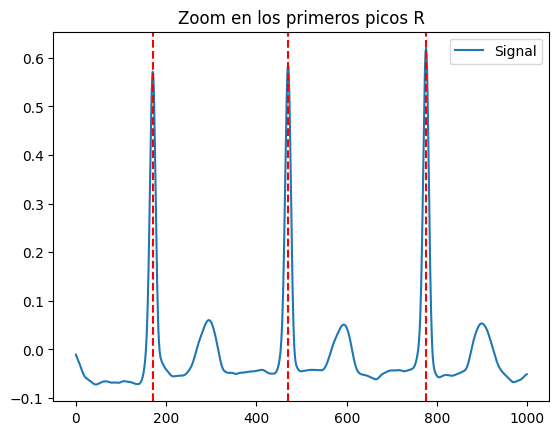

In [ ]:
ecg_cleanedAFIB = señalAFIB["ECG_Clean"]

r_peaksAFIB, info_peaksAFIB = nk.ecg_peaks(ecg_cleanedAFIB,sampling_rate=500,method="neurokit",correct_artifacts=False,show=False)

rpeaks_positionsAFIB = info_peaksAFIB["ECG_R_Peaks"]
print("Picos R detectados (muestras):", info_peaksAFIB["ECG_R_Peaks"])
plt.figure(figsize=(10, 4))
plt.plot(ecg_cleanedAFIB, label="ECG Limpiado", alpha=0.7)
plt.scatter(info_peaksAFIB["ECG_R_Peaks"], ecg_cleanedAFIB[info_peaksAFIB["ECG_R_Peaks"]],
            color="red", label="Picos R detectados")
plt.title("Detección de Picos R")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()
plt.show()

# Acercamiento a los primeros 5 picos R
nk.events_plot(rpeaks_positionsAFIB[:3], ecg_cleanedAFIB[:1000])
plt.title("Zoom en los primeros picos R")
plt.show()

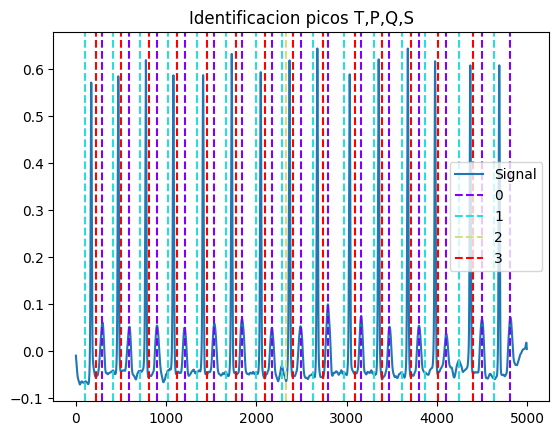

In [ ]:
rpeaks_positionsAFIB = infoAFIB["ECG_R_Peaks"]

# Delinear la señal de ECG para identificar ondas P, Q, R, S, y T
_, waves_peak = nk.ecg_delineate(ecg_cleanedAFIB,rpeaks=rpeaks_positionsAFIB,sampling_rate=500,method="dwt",show=False)

#ondas (P, Q, R, S, T)
plot = nk.events_plot(
    [
        waves_peak["ECG_T_Peaks"][:20],  # Ondas T
        waves_peak["ECG_P_Peaks"][:20],  # Ondas P
        waves_peak["ECG_Q_Peaks"][:20],  # Ondas Q
        waves_peak["ECG_S_Peaks"][:20]   # Ondas S
    ],
    ecg_cleanedAFIB[:5000]
)

plt.title("Identificacion picos T,P,Q,S")
plt.show()

In [ ]:
ecg_phasesAFIB = nk.ecg_phase(ecg_cleanedAFIB,rpeaks=rpeaks_positionsAFIB,delineate_info=waves_peak,sampling_rate=500)


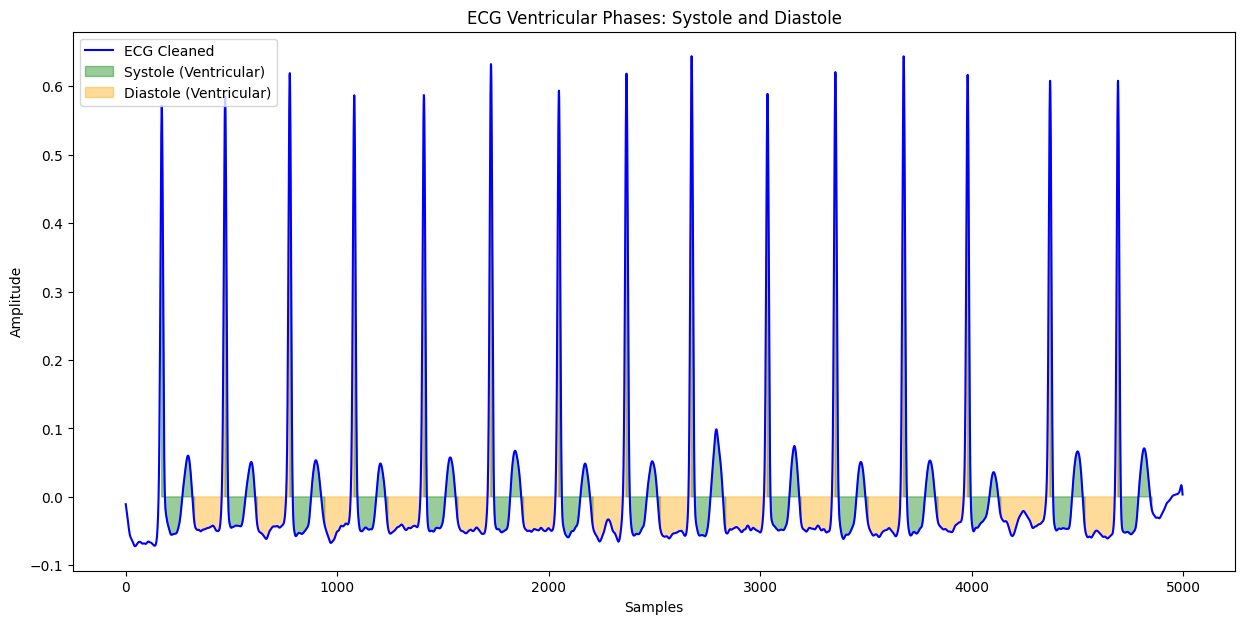

In [ ]:
# Obtener las fases ventriculares del ECG
ventricular_phaseAFIB = ecg_phasesAFIB["ECG_Phase_Ventricular"]

# Visualizar las fases del ECG
plt.figure(figsize=(15, 7))

# Graficar la señal limpia de ECG
plt.plot(ecg_cleanedAFIB[:5000], label="ECG Cleaned", color="blue")

# Graficar las fases ventriculares
plt.fill_between(
    range(len(ventricular_phaseAFIB[:5000])),
    ecg_cleanedAFIB[:5000],
    where=(ventricular_phaseAFIB[:5000] == 1),  # Sístole
    color="green",
    alpha=0.4,
    label="Systole (Ventricular)"
)
plt.fill_between(
    range(len(ventricular_phaseAFIB[:5000])),
    ecg_cleanedAFIB[:5000],
    where=(ventricular_phaseAFIB[:5000] == 0),  # Diástole
    color="orange",
    alpha=0.4,
    label="Diastole (Ventricular)"
)

plt.title("ECG Ventricular Phases: Systole and Diastole")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

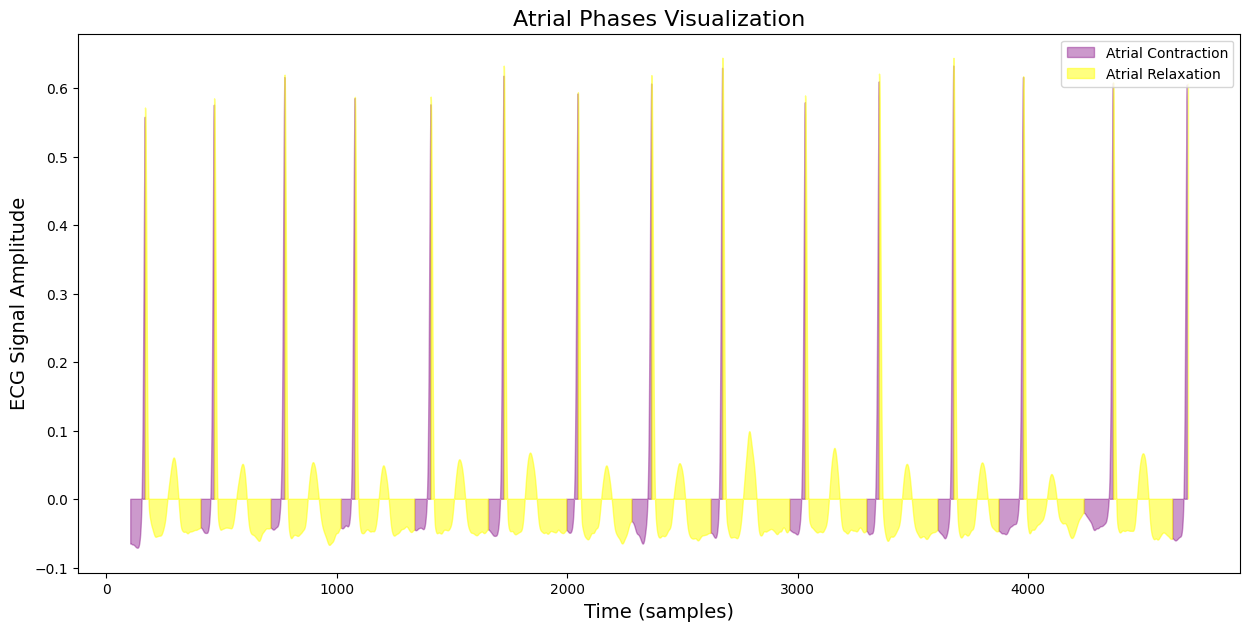

In [ ]:
atrial_phaseAFIB = ecg_phasesAFIB["ECG_Phase_Atrial"]
plt.figure(figsize=(15, 7))
plt.fill_between(
    range(len(atrial_phaseAFIB[:5000])),
    ecg_cleanedAFIB[:5000],
    where=(atrial_phaseAFIB[:5000] == 1),  # Contracción auricular
    color="purple",
    alpha=0.4,
    label="Atrial Contraction"
)
plt.fill_between(
    range(len(atrial_phaseAFIB[:5000])),
    ecg_cleanedAFIB[:5000],
    where=(atrial_phaseAFIB[:5000] == 0),  # Relajación auricular
    color="yellow",
    alpha=0.5,
    label="Atrial Relaxation"
)

plt.legend()
plt.title("Atrial Phases Visualization", fontsize=16)
plt.xlabel("Time (samples)", fontsize=14)
plt.ylabel("ECG Signal Amplitude", fontsize=14)

plt.show()

In [ ]:
# Extract clean EDA and SCR features
hrv_time = nk.hrv_time(r_peaksAFIB, sampling_rate=500)
hrv_time

HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  646.142857  48.513055         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  73.779297  76.718266  ...       32.5     0.657543   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        611.2        650.8  28.571429  57.142857      600.0      780.0   

   HRV_HTI  HRV_TINN  
0      3.5    46.875  

[1 rows x 25 columns]

### **5.** Con las características que extrae el neurokit y las discutidas en el punto 1 generar un conjunto de características para el presente trabajo. Incluir la característica de frecuencia de potencia máxima del Proyecto 3 (10%). No incluir más de 15 características ni menos de 5, justificar la selección (5%).



Para la extracción de característica, se emplearán las ya proporcionadas por el archivo 'Diagnostics': edad y género.

De acuerdo con el artículo 'optimal Multi-Stage Arrhythmia
Classification Approach' incluir características demográficas como la edad y el género son importantes debido a relevancia en el análisis de datos médicos.
Además, son características importantes para la clasificación de arritmias, ya que la edad avanzada por ejemplo se ha asociado con intervalos PR más largos y una mayor duración del complejo QRS en ambos sexos. Estos cambios en los parámetros del ECG son importantes para la identificación de patologías como fibrilación auricular y bradicardia sinusal [4].

Adicionalmente, se incluirá como característica la frecuencia de máxima potencia (fMP), que al utilizar el método de Fourier, permite obtener la densidad espectral de potencia (PSD). La PSD proporciona una representación cuantitativa de cómo se distribuye la potencia a través de las diferentes frecuencias de una señal. Esta característica es particularmente útil en el análisis de señales fisiológicas como el ECG, ya que permite identificar componentes de frecuencia asociados con ritmos cardíacos normales o anormales, facilitando la identificación de arritmias y otras afecciones cardíacas [5].

Y finalmente, las caracteristicas que consideramos importantes de la herramienta neurokit, mediante las funciones son:

- ECG_Rate: El promedio de la frecuencia cardíaca es una característica relevante porque permite diferenciar entre diversas patologías cardíacas. Por ejemplo, en pacientes con fibrilación auricular, se observa una frecuencia elevada e irregular, superior a los 100 latidos por minuto (bpm). Por su parte, en pacientes con bradicardia sinusal, la frecuencia cardíaca es más lenta de lo normal, por debajo de los 60 bpm [6]. Por lo cual es importante en la clasificación de arritmias, facilitando la identificación de ritmos anormales en el ECG.

- ECG_R_Peaks y ECG_P_Peaks: De acuerdo con la información proporcionada [3], los picos P son cruciales para identificar la fibrilación auricular, ya que la ausencia de estos picos es un indicio de la presencia de esta patología. La falta de ondas P es un indicio clave en el electrocardiograma (ECG) de pacientes con fibrilación auricular, lo que hace que la suma de los picos P presentes en la señal sea una característica relevante y útil para la clasificación de arritmias, facilitando la identificación de ritmos cardíacos anormales. Por otra parte, la onda R es una de las secciones más importantes del complejo QRS, que tiene un papel esencial en el diagnóstico de irregularidades del ritmo cardíaco y también en la determinación de la variabilidad de la frecuencia cardíaca [7], por ello la suma de los picos presentes en la señal es una caracteristica relevante debido a que permite detectar posibles arritmias, y al igual que los picos P ayudan a identificar los ritmos cardiacos anormales en la clasificación de las señales como parte de la predicción.

- ECG_Phase_Ventricular: Este promedio es una característica relevante porque proporciona información sobre la fase de la contracción ventricular, que está asociada con la actividad eléctrica del corazón. El análisis de esta fase puede identificar alteraciones en la conducción ventricular. El contenido del complejo QRS generalmente se encuentra en el rango de frecuencias de 8-50 Hz, pero una conducción ventricular anormal puede caracterizarse por frecuencias mayores a 70 Hz, lo que puede generar muescas en el complejo QRS, indicativo de arritmias o patologías cardíacas [8].

- HRV_MeanNN por la función hrv_time(): Es medida como el promedio de la señal y es una característica relevante porque una variabilidad reducida se ha asociado con un mayor riesgo de problemas de salud cardiovascular, como enfermedades cardíacas. La medición de la HRV es útil para detectar disfunciones que pueden derivar en patologías graves como arritmias o insuficiencia cardíaca [9].

<blockquote>

Con el propósito de garantizar una equivalencia en la cantidad de datos, como se menciono en clase, se tomaron 1000 registros correspondientes a pacientes con ritmo sinusal bradicárdico (SB) y 1000 registros correspondientes a pacientes con fibrilación auricular (AFIB), lo que da un total de 2000 registros. Esta selección busca evitar el sesgo derivado de una distribución desbalanceada de datos, lo que podría influir negativamente en el rendimiento y la capacidad de generalización del modelo de clasificación.

Además, limitar la cantidad de registros a 1000 por clase tiene el objetivo de optimizar los recursos computacionales disponibles para el procesamiento y entrenamiento de la red neuronal. Un número mayor de datos podría incrementar significativamente los tiempos de cálculo sin necesariamente mejorar la calidad del modelo, especialmente considerando que los datos seleccionados son representativos del total. La necesidad de garantizar un equilibrio en el conjunto de entrenamiento y validación. Un dataset balanceado permite que el modelo aprenda de manera equitativa las características de cada categoría.

</blockquote>

> Las características de Edad y Genero se extraen de la información del archivo Diagnostics.

In [ ]:
filtros = df[df['Rhythm'].isin(['SB', 'AFIB'])]

def edad_sexo(filtros, archivos_SB, archivos_AFIB):
    # primeros 1000 registros para SB y AFIB
    registros_SB = archivos_SB[:1000]
    registros_AFIB = archivos_AFIB[:1000]

    # Combinar los registros seleccionados de SB y AFIB
    registros_seleccionados = registros_SB + registros_AFIB

    # se filtran los registros seleccionados
    data_seleccionada = filtros[filtros['FileName'].isin([archivo.split('.')[0] for archivo in registros_seleccionados])]

    # dataframe final
    df_final = data_seleccionada[['FileName', 'PatientAge', 'Gender']].rename(
        columns={'FileName': 'Registro', 'PatientAge': 'Edad', 'Gender': 'Sexo'}
    )
    df_final = df_final[['Registro', 'Edad', 'Sexo']].reset_index(drop=True)

    return df_final

df_edad_sexo = edad_sexo(filtros, archivos_SB, archivos_AFIB)

df_edad_sexo


Registro  Edad    Sexo
0     MUSE_20180113_171327_27000    85    MALE
1     MUSE_20180112_073319_29000    59  FEMALE
2     MUSE_20180114_070718_20000    74    MALE
3     MUSE_20180114_121218_64000    61    MALE
4     MUSE_20180116_123940_90000    81    MALE
...                          ...   ...     ...
1995  MUSE_20180115_131040_20000    81  FEMALE
1996  MUSE_20180114_122714_33000    47    MALE
1997  MUSE_20180114_134724_10000    56  FEMALE
1998  MUSE_20180114_074720_85000    55  FEMALE
1999  MUSE_20180115_131524_93000    70    MALE

[2000 rows x 3 columns]

La caracteristica de la frecuencia maxima de potencia se extrae del proyecto 2, la cual se calculo con Fourier.

In [ ]:
# Carga del dataframe obtenido en en anterior proyecto
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataFrame.csv')

data

Registro Estado  fMP(Hz)  sFSB
0     MUSE_20180116_132337_80000.csv   AFIB      2.5     1
1     MUSE_20180712_160542_23000.csv   AFIB      6.3    76
2     MUSE_20180113_132107_62000.csv   AFIB      4.0    51
3     MUSE_20180116_170744_66000.csv   AFIB      1.6    76
4     MUSE_20180116_122717_82000.csv   AFIB      4.1    68
...                              ...    ...      ...   ...
5664  MUSE_20180113_183540_30000.csv     SB      2.9    17
5665  MUSE_20180112_133103_33000.csv     SB      2.9    55
5666  MUSE_20180115_115626_42000.csv     SB      3.4   109
5667  MUSE_20180113_182022_25000.csv     SB      1.8    30
5668  MUSE_20180113_185246_68000.csv     SB      0.9   106

[5669 rows x 4 columns]

In [ ]:

data['Registro'] = data['Registro'].str.replace('.csv', '', regex=False)


df_combinado = df_edad_sexo.merge(data[['Registro', 'fMP(Hz)', 'Estado']], on='Registro', how='left')

# Resultado
df_combinado

Registro  Edad    Sexo  fMP(Hz) Estado
0     MUSE_20180113_171327_27000    85    MALE      9.0   AFIB
1     MUSE_20180112_073319_29000    59  FEMALE      2.6     SB
2     MUSE_20180114_070718_20000    74    MALE      4.3     SB
3     MUSE_20180114_121218_64000    61    MALE      2.9     SB
4     MUSE_20180116_123940_90000    81    MALE      9.7   AFIB
...                          ...   ...     ...      ...    ...
1995  MUSE_20180115_131040_20000    81  FEMALE      3.3   AFIB
1996  MUSE_20180114_122714_33000    47    MALE      1.9     SB
1997  MUSE_20180114_134724_10000    56  FEMALE      2.8     SB
1998  MUSE_20180114_074720_85000    55  FEMALE     15.3     SB
1999  MUSE_20180115_131524_93000    70    MALE      2.6   AFIB

[2000 rows x 5 columns]

<blockquote>

Para mayor claridad, las características en el DataFrame se nombran de la siguiente manera:

* Frecuencia cardica (ECG rate), se toma el promedio de cada señal.

* Picos R de la señal (ECG_R_Peaks), se toma el total de picos R en cada señal.

* Picos P de la señal (ECG_P_Peaks), se toma el total de picos p en cada señal.

* Fase ventricular (ECG_Phase_Ventricular), se toma el promedio en cada señal.

* Variabilidad de la frecuencia cardíaca (HRV_MeanNN), se toma el promedio en cada señal.

</blockquote>

In [ ]:
registros_SB = archivos_SB[:1000]
registros_AFIB = archivos_AFIB[:1000]

def procesar_senales(datos_ecg, registros_seleccionados):
    resultados = []

    for registro in registros_seleccionados:

        señal = datos_ecg.get(registro, None)
        if señal is not None:
            # Verificar si la longitud de la señal es suficiente
            if len(señal) < 2000:
                print(f"Advertencia: La señal del registro {registro} tiene menos de 2000 muestras y será excluida.")
                continue  # Saltar este registro

            try:
                # procesamiento
                ecg_signals, ecg_info = nk.ecg_process(señal, sampling_rate=500)

                # características
                frecuencia_cardiaca = np.mean(ecg_signals['ECG_Rate'])
                picos_r = np.sum(ecg_signals['ECG_R_Peaks'])
                picos_p = np.sum(ecg_signals['ECG_P_Peaks'])
                fase_ventricular = np.mean(ecg_signals['ECG_Phase_Ventricular'])

                # HRV
                hrv_indices = nk.hrv_time(ecg_signals, sampling_rate=500)
                hrv_mean_nn = hrv_indices.get('HRV_MeanNN', pd.Series([np.nan])).values[0]  # Usar escalar

                resultados.append([registro, frecuencia_cardiaca, picos_r, picos_p, fase_ventricular, hrv_mean_nn])

            except Exception as e:
                print(f"Error al procesar el registro {registro}: {e}")
                continue  # Saltar si ocurre un error

    df_resultados = pd.DataFrame(resultados, columns=[
        'Registro', 'Heart_Rate', 'R_Peaks',
        'P_Peaks', 'Phase_Vent', 'HRV'
    ])

    return df_resultados

df_resultados_sb = procesar_senales(datos_ecg_sb_procesados, registros_SB)
df_resultados_afib = procesar_senales(datos_ecg_afib_procesados, registros_AFIB)

# Combinar los resultados
df_resultados_totales = pd.concat([df_resultados_sb, df_resultados_afib], ignore_index=True)

df_resultados_totales


/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error al procesar el registro MUSE_20180114_124930_50000.csv: cannot convert float NaN to integer


/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error al procesar el registro MUSE_20180115_122527_35000.csv: cannot convert float NaN to integer


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error al procesar el registro MUSE_20180116_173718_14000.csv: integer division or modulo by zero


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error al procesar el registro MUSE_20180113_121039_40000.csv: integer division or modulo by zero


Registro  Heart_Rate  R_Peaks  P_Peaks  \
0     MUSE_20180118_182158_26000.csv   53.569344        9        8   
1     MUSE_20180115_122148_83000.csv   58.837846        9        9   
2     MUSE_20180118_122029_78000.csv   60.597682       10       10   
3     MUSE_20180119_174513_85000.csv   59.034152       10       10   
4     MUSE_20180113_123833_74000.csv   56.493107        9        9   
...                              ...         ...      ...      ...   
1991  MUSE_20180119_172414_29000.csv   98.714894       16       14   
1992  MUSE_20180113_124536_75000.csv   86.590610       12       12   
1993  MUSE_20180115_131246_23000.csv  105.169204       16       16   
1994  MUSE_20180118_180227_10000.csv   92.969745       15       15   
1995  MUSE_20180114_133928_84000.csv   63.750968       10       10   

      Phase_Vent          HRV  
0       0.346632  1120.250000  
1       0.367184  1019.500000  
2       0.333187  1008.888889  
3       0.267322  1016.444444  
4       0.371030  1063.250000  
...          ...          ...  
1991    0.371225   618.000000  
1992    0.475245   728.545455  
1993    0.335232   575.066667  
1994    0.345341   650.000000  
1995    0.308523   945.333333  

[1996 rows x 6 columns]

In [ ]:
# Se almacena el dataframe en un archivo CSV
df_resultados_totales.to_csv('Caracteristicas.csv', index=False)

In [ ]:
caracteristics = pd.read_csv('Caracteristicas.csv')

caracteristics

Registro  Heart_Rate  R_Peaks  P_Peaks  \
0     MUSE_20180118_182158_26000.csv   53.569344        9        8   
1     MUSE_20180115_122148_83000.csv   58.837846        9        9   
2     MUSE_20180118_122029_78000.csv   60.597682       10       10   
3     MUSE_20180119_174513_85000.csv   59.034152       10       10   
4     MUSE_20180113_123833_74000.csv   56.493107        9        9   
...                              ...         ...      ...      ...   
1991  MUSE_20180119_172414_29000.csv   98.714894       16       14   
1992  MUSE_20180113_124536_75000.csv   86.590610       12       12   
1993  MUSE_20180115_131246_23000.csv  105.169204       16       16   
1994  MUSE_20180118_180227_10000.csv   92.969745       15       15   
1995  MUSE_20180114_133928_84000.csv   63.750968       10       10   

      Phase_Vent          HRV  
0       0.346632  1120.250000  
1       0.367184  1019.500000  
2       0.333187  1008.888889  
3       0.267322  1016.444444  
4       0.371030  1063.250000  
...          ...          ...  
1991    0.371225   618.000000  
1992    0.475245   728.545455  
1993    0.335232   575.066667  
1994    0.345341   650.000000  
1995    0.308523   945.333333  

[1996 rows x 6 columns]

Se elimina el .csv del nombre de los registros, de modo que se pueda concatenar los dataframes en base al nombre del registro.

In [ ]:
caracteristics['Registro'] = caracteristics['Registro'].str.replace('.csv', '', regex=False)
caracteristics

Registro  Heart_Rate  R_Peaks  P_Peaks  Phase_Vent  \
0     MUSE_20180118_182158_26000   53.569344        9        8    0.346632   
1     MUSE_20180115_122148_83000   58.837846        9        9    0.367184   
2     MUSE_20180118_122029_78000   60.597682       10       10    0.333187   
3     MUSE_20180119_174513_85000   59.034152       10       10    0.267322   
4     MUSE_20180113_123833_74000   56.493107        9        9    0.371030   
...                          ...         ...      ...      ...         ...   
1991  MUSE_20180119_172414_29000   98.714894       16       14    0.371225   
1992  MUSE_20180113_124536_75000   86.590610       12       12    0.475245   
1993  MUSE_20180115_131246_23000  105.169204       16       16    0.335232   
1994  MUSE_20180118_180227_10000   92.969745       15       15    0.345341   
1995  MUSE_20180114_133928_84000   63.750968       10       10    0.308523   

              HRV  
0     1120.250000  
1     1019.500000  
2     1008.888889  
3     1016.444444  
4     1063.250000  
...           ...  
1991   618.000000  
1992   728.545455  
1993   575.066667  
1994   650.000000  
1995   945.333333  

[1996 rows x 6 columns]

### **6.** Crear una rutina que aplique sobre todos los archivos de la base de datos la rutina 5 y almacene los resultados en un dataframe

Se combinan el dataframe con las caracteristicas demograficas y el de las caracteristicas obtenidas a partir de neurokit2.

In [ ]:

df_final = df_combinado.merge(caracteristics, on='Registro', how='inner')
df_final


Registro  Edad    Sexo  fMP(Hz) Estado  Heart_Rate  \
0     MUSE_20180113_171327_27000    85    MALE      9.0   AFIB  117.371505   
1     MUSE_20180112_073319_29000    59  FEMALE      2.6     SB   51.754235   
2     MUSE_20180114_070718_20000    74    MALE      4.3     SB   60.867164   
3     MUSE_20180114_121218_64000    61    MALE      2.9     SB   58.319811   
4     MUSE_20180116_123940_90000    81    MALE      9.7   AFIB   79.244823   
...                          ...   ...     ...      ...    ...         ...   
1991  MUSE_20180115_131040_20000    81  FEMALE      3.3   AFIB   70.368174   
1992  MUSE_20180114_122714_33000    47    MALE      1.9     SB   56.726358   
1993  MUSE_20180114_134724_10000    56  FEMALE      2.8     SB   56.027209   
1994  MUSE_20180114_074720_85000    55  FEMALE     15.3     SB   56.898626   
1995  MUSE_20180115_131524_93000    70    MALE      2.6   AFIB   94.585263   

      R_Peaks  P_Peaks  Phase_Vent          HRV  
0          19       17    0.346904   512.555556  
1           8        8    0.345420  1160.571429  
2          10       10    0.504117  1016.666667  
3          10       10    0.353982  1029.333333  
4          13       13    0.290667   764.166667  
...       ...      ...         ...          ...  
1991       12       12    0.180258   858.181818  
1992        9        9    0.324905  1057.750000  
1993        9        9    0.390130  1070.750000  
1994        9        9    0.240931  1053.750000  
1995       15       15    0.427563   647.714286  

[1996 rows x 10 columns]

### **7.** Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red (10%) y las matrices de confusión obtenidas (10%), de una red neuronal que permita la clasificación de las dos patologías cardiacas.

Antes de comenzar con la predicción utilizando una red neuronal, es fundamental realizar un proceso de normalización de las variables numéricas del DataFrame. Este paso es crucial porque en una red neuronal, las diferencias en las escalas de las variables pueden afectar negativamente el entrenamiento. Algunas características pueden dominar sobre otras debido a sus magnitudes más altas, lo que resulta en un modelo mal ajustado.

El método de normalización elegido es el Z-Score, también conocido como estandarización. Este método transforma las variables numéricas de manera que tengan una media de 0 y una desviación estándar de 1 [10]. La fórmula para calcular el Z-Score es la siguiente:


$$
Z = \frac{X - \mu}{\sigma}
$$

Donde:
$$
X: \text{Valor original.}
$$
$$
\mu: \text{Media de la variable.}
$$
$$
\sigma: \text{Desviación estándar de la variable.}
$$



In [ ]:
from sklearn.preprocessing import StandardScaler

# columnas numéricas
numeric_columns = df_final.select_dtypes(include=['float64', 'int64']).columns

# Inicializar el escalador
scaler = StandardScaler()

# Se aplica Z-Score a las columnas numéricas
df_final[numeric_columns] = scaler.fit_transform(df_final[numeric_columns])

from IPython.display import display

display(df_final)

Registro      Edad    Sexo   fMP(Hz) Estado  \
0     MUSE_20180113_171327_27000  1.290534    MALE  1.953570   AFIB   
1     MUSE_20180112_073319_29000 -0.476345  FEMALE -0.336194     SB   
2     MUSE_20180114_070718_20000  0.543008    MALE  0.272024     SB   
3     MUSE_20180114_121218_64000 -0.340431    MALE -0.228862     SB   
4     MUSE_20180116_123940_90000  1.018706    MALE  2.204012   AFIB   
...                          ...       ...     ...       ...    ...   
1991  MUSE_20180115_131040_20000  1.018706  FEMALE -0.085751   AFIB   
1992  MUSE_20180114_122714_33000 -1.291828    MALE -0.586637     SB   
1993  MUSE_20180114_134724_10000 -0.680216  FEMALE -0.264639     SB   
1994  MUSE_20180114_074720_85000 -0.748173  FEMALE  4.207556     SB   
1995  MUSE_20180115_131524_93000  0.271181    MALE -0.336194   AFIB   

      Heart_Rate   R_Peaks   P_Peaks  Phase_Vent       HRV  
0       1.506104  1.596322  2.288904   -0.478399 -1.441948  
1      -0.913823 -0.988782 -1.007382   -0.487356  1.140406  
2      -0.577744 -0.518763 -0.274874    0.470785  0.566943  
3      -0.671689 -0.518763 -0.274874   -0.435662  0.617420  
4       0.100014  0.186265  0.823888   -0.817931 -0.439274  
...          ...       ...       ...         ...       ...  
1991   -0.227352 -0.048744  0.457634   -1.484534 -0.064622  
1992   -0.730454 -0.753773 -0.641128   -0.611215  0.730661  
1993   -0.756239 -0.753773 -0.641128   -0.217420  0.782466  
1994   -0.724101 -0.753773 -0.641128   -1.118219  0.714721  
1995    0.665760  0.656284  1.556396    0.008590 -0.903338  

[1996 rows x 10 columns]

El siguiente paso en el preprocesamiento de los datos consiste en transformar las variables categóricas en valores numéricos mediante una codificación binaria, lo cual es esencial para que los modelos de aprendizaje automático, incluidas las redes neuronales, puedan procesarlas. En este caso, trabajaremos con las columnas `Sexo` y `Estado`.

Comenzamos con la columna `Sexo`. En este caso, los valores `MALE` serán representados como `0` y `FEMALE` como `1`. Esta transformación no tiene ninguna implicación jerárquica, simplemente asigna un valor numérico que permite al modelo interpretar esta variable nominal como parte del conjunto de características. Es importante realizar esta transformación porque las redes neuronales no pueden procesar directamente datos categóricos y necesitan que todas las entradas estén en un formato numérico estándar.

A continuación, procedemos con la columna `Estado`, que es nuestra variable objetivo o de predicción. Esta columna describe la condición de los pacientes: `AFIB`, que corresponde a fibrilación auricular (una condición cardíaca anormal), y `SB`, que se refiere a bradicardia sinusal (un ritmo cardíaco normal pero lento). Asignaremos a `AFIB` el valor `1` y a `SB` el valor `0`.

Tambien se elimna la columna `Registro` ya que no es necesaria para realizar el entrenamiento del modelo.

In [ ]:
# MALE -> 0, FEMALE -> 1
df_final['Sexo'] = df_final['Sexo'].map({'MALE': 0, 'FEMALE': 1})

# AFIB -> 1, SB -> 0
df_final['Estado'] = df_final['Estado'].map({'AFIB': 1, 'SB': 0})

# Se elimina la columna de registros
df_final = df_final.drop(columns=['Registro'])
df_final

Edad  Sexo   fMP(Hz)  Estado  Heart_Rate   R_Peaks   P_Peaks  \
0     1.290534     0  1.953570       1    1.506104  1.596322  2.288904   
1    -0.476345     1 -0.336194       0   -0.913823 -0.988782 -1.007382   
2     0.543008     0  0.272024       0   -0.577744 -0.518763 -0.274874   
3    -0.340431     0 -0.228862       0   -0.671689 -0.518763 -0.274874   
4     1.018706     0  2.204012       1    0.100014  0.186265  0.823888   
...        ...   ...       ...     ...         ...       ...       ...   
1991  1.018706     1 -0.085751       1   -0.227352 -0.048744  0.457634   
1992 -1.291828     0 -0.586637       0   -0.730454 -0.753773 -0.641128   
1993 -0.680216     1 -0.264639       0   -0.756239 -0.753773 -0.641128   
1994 -0.748173     1  4.207556       0   -0.724101 -0.753773 -0.641128   
1995  0.271181     0 -0.336194       1    0.665760  0.656284  1.556396   

      Phase_Vent       HRV  
0      -0.478399 -1.441948  
1      -0.487356  1.140406  
2       0.470785  0.566943  
3      -0.435662  0.617420  
4      -0.817931 -0.439274  
...          ...       ...  
1991   -1.484534 -0.064622  
1992   -0.611215  0.730661  
1993   -0.217420  0.782466  
1994   -1.118219  0.714721  
1995    0.008590 -0.903338  

[1996 rows x 9 columns]

Se divide nuestro DataFrame en 80% de los datos para validacion y 20% para entrenamiento, con las misma proporciones de SB y AFIB en estos porcentajes.

In [ ]:
# Se separa AFIB y SB
df_sb = df_final[df_final['Estado'] == 0]
df_afib = df_final[df_final['Estado'] == 1]


In [ ]:
from sklearn.model_selection import train_test_split

#registros para entrenamiento y validación
train_size_sb = 800
val_size_sb = 200
train_size_afib = 797
val_size_afib = 199

train_sb, val_sb = train_test_split(
    df_sb, train_size=train_size_sb, test_size=val_size_sb, random_state=42)

train_afib, val_afib = train_test_split(
    df_afib, train_size=train_size_afib, test_size=val_size_afib, random_state=42)

print(f"Entrenamiento SB: {len(train_sb)}, Validación SB: {len(val_sb)}")
print(f"Entrenamiento AFIB: {len(train_afib)}, Validación AFIB: {len(val_afib)}")

Entrenamiento SB: 800, Validación SB: 200
Entrenamiento AFIB: 797, Validación AFIB: 199


In [ ]:
# Se combinan los conjuntos de entrenamiento y validación
df_train = pd.concat([train_sb, train_afib]).sample(frac=1, random_state=42)
df_test = pd.concat([val_sb, val_afib]).sample(frac=1, random_state=42)

In [ ]:
df_train

Edad  Sexo   fMP(Hz)  Estado  Heart_Rate   R_Peaks   P_Peaks  \
647   0.271181     1  0.772910       1    1.599063  1.596322  1.556396   
1518 -0.068604     0 -0.944413       0   -0.772254 -0.753773 -0.641128   
208  -0.544302     0 -0.049974       0    1.113715  0.891294 -1.373636   
740  -0.204518     0  0.093136       0   -0.742881 -0.753773 -0.641128   
282   0.475051     0 -0.479305       1   -0.755096 -0.753773 -0.641128   
...        ...   ...       ...     ...         ...       ...       ...   
146  -0.204518     0  0.450912       1    0.358053  0.421275  0.091380   
1240  0.746879     0 -0.515082       1   -0.577354 -0.753773 -0.641128   
1417  1.086663     0 -0.085751       1   -0.049243 -0.048744  0.457634   
852   0.067310     0 -0.014196       1    0.833788  0.891294 -0.641128   
435   0.543008     0 -0.300417       1   -0.121299 -0.283754  0.091380   

      Phase_Vent       HRV  
647     0.897091 -1.470286  
1518   -0.428370  0.818331  
208     0.943636 -1.071165  
740    -0.321166  0.755567  
282     0.374676  0.768519  
...          ...       ...  
146    -1.173698 -0.672908  
1240   -0.462420  0.617088  
1417    0.117113 -0.294304  
852     0.966641 -1.066914  
435    -0.942281 -0.129904  

[1597 rows x 9 columns]

In [ ]:
df_test

Edad  Sexo   fMP(Hz)  Estado  Heart_Rate   R_Peaks   P_Peaks  \
1200  0.203224     0 -0.264639       0   -0.753782 -0.753773 -0.641128   
1978  0.067310     1 -0.264639       1    0.109818  0.186265  0.823888   
982  -0.816129     0 -0.944413       0   -0.815456 -0.753773 -0.641128   
1358  0.950749     0  4.279111       1    0.471546  0.656284  1.556396   
406  -0.272474     0 -0.908635       0   -0.628707 -0.518763 -0.274874   
...        ...   ...       ...     ...         ...       ...       ...   
972  -0.204518     1 -0.908635       0   -0.644454 -0.753773 -0.641128   
1087 -0.816129     1  0.093136       0   -0.732284 -0.753773 -0.641128   
863   1.766232     0  0.057359       1    1.031492  1.126303  1.556396   
134  -0.748173     0  0.200469       1    0.354565  0.421275  1.190142   
1869 -0.272474     1 -0.407749       0   -0.623068 -0.518763 -0.274874   

      Phase_Vent       HRV  
1200   -0.399167  0.779477  
1978   -0.006593 -0.468497  
982    -0.575813  0.917957  
1358   -0.594293 -0.792327  
406    -0.287280  0.496098  
...          ...       ...  
972    -0.090049  0.562294  
1087   -0.236346  0.735642  
863     0.650874 -1.203069  
134    -0.167499 -0.683944  
1869   -0.183414  0.575799  

[399 rows x 9 columns]

### MLPClassifier

El MLPClassifier (clasificador de perceptrón multicapa) es un modelo de aprendizaje automático basado en redes neuronales que se utiliza para tareas de clasificación. Este modelo pertenece a la familia de redes neuronales feedforward, donde los datos fluyen desde la capa de entrada, pasando por una o más capas ocultas, hasta llegar a la capa de salida [28]. Su capacidad para aprender patrones no lineales lo hace especialmente adecuado para problemas complejos como el que nos ocupa: la clasificación de señales cardíacas entre fibrilación auricular (AFIB) y bradicardia sinusal (SB).

En este contexto, se selecciona el MLPClassifier porque ofrece varias ventajas. Primero, su capacidad para modelar relaciones no lineales es crucial para las características extraídas del ECG, como la frecuencia cardíaca, los picos R y P, y las métricas de variabilidad. Estas características no tienen relaciones lineales simples y requieren un modelo que pueda capturar interacciones complejas. Segundo, el problema es de clasificación binaria, lo que lo hace perfectamente compatible con la estructura del MLPClassifier, donde la capa de salida puede configurarse para devolver la probabilidad de cada clase. Finalmente, el modelo es escalable y permite ajustar parámetros como el número de capas ocultas y neuronas, adaptándose a las necesidades específicas del conjunto de datos.

Se definen entonces los datos de entrenamiento y de validacion (prueba)

In [ ]:
from sklearn.model_selection import train_test_split

X_train = df_train.drop(columns=['Estado'])  # Características
y_train = df_train['Estado']                 # Variable objetivo

X_test = df_test.drop(columns=['Estado'])    # Características
y_test = df_test['Estado']                   # Variable objetivo

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1597, 8), y_train: (1597,)
X_test: (399, 8), y_test: (399,)


En este análisis se van a desarrollar tres modelos con tres diferentes arquitecturas, cada uno diseñado para evaluar cómo el nivel de complejidad del modelo afecta su capacidad de aprendizaje y generalización. La variación de los hiperparámetros en las diferentes arquitecturas propuestas para los modelos se ha realizado tomando como base la siguiente ecuacion.

$$
\text{Número de neuronas} = \frac{\text{muestras de datos}}{\text{factor} \cdot (\text{neuronas de entrada} + \text{neuronas de salida})}
$$

Que es una guía para determinar el número óptimo de neuronas en las capas ocultas. Esta fórmula permite un ajuste balanceado entre la capacidad del modelo para aprender patrones complejos y el control del sobreajuste, lo cual es especialmente relevante en problemas donde el tamaño del dataset no es excesivamente grande.

La ecuación se utilizó para calcular un número razonable de neuronas en las capas ocultas de cada modelo, y los resultados fueron escalados progresivamente para ajustar la complejidad en las arquitecturas “Básica”, “Intermedia” y “Avanzada”:

1. Modelo **“Básico”**:
- Arquitectura: Una sola capa oculta con 54 neuronas. Este número fue calculado usando la fórmula, considerando las muestras de datos, las características de entrada y las clases de salida. Se utilizó un factor moderado para lograr una buena capacidad de aprendizaje sin incurrir en sobreajuste.

2.	Modelo **“Intermedio”**:
- Arquitectura: Dos capas ocultas con 54 y 26 neuronas. La primera capa sigue la fórmula para maximizar la capacidad de aprendizaje. La segunda capa se diseñó con aproximadamente la mitad del tamaño de la primera, siguiendo buenas prácticas en redes neuronales que buscan simplificar gradualmente las representaciones.

3. Modelo **“Avanzado”**:
- Arquitectura: Tres capas ocultas con 54, 26 y 14 neuronas. Este modelo incorpora una tercera capa oculta con un número reducido de neuronas (aproximadamente la mitad de la capa anterior) para aprender representaciones más refinadas y específicas.

A continuacion se muestra la configuracion general del modelo para garantizar un entrenamiento eficiente y un buen rendimiento:

1. `activation = 'relu'` (Función de activación):
- ReLU es ideal para capturar relaciones no lineales en los datos. Es computacionalmente eficiente y evita problemas de saturación, como los que ocurren con funciones como sigmoide o tanh.

2.	`solver = 'adam'` (Algoritmo de optimización):
- Adam combina la adaptabilidad de la tasa de aprendizaje de RMSProp con la estabilidad del gradiente estocástico. Es rápido, robusto y excelente para problemas con muchos parámetros.

3.	`batch_size = 64` (Tamaño de lote):
- Un tamaño moderado como 64 balancea estabilidad y velocidad de entrenamiento, ademas es adecuado para optimizadores como Adam [12].

4.	`learning_rate_init = 0.001` (Tasa de aprendizaje inicial):
- Este valor estándar para Adam permite ajustes graduales de los pesos, evitando saltos inestables y favoreciendo una convergencia estable [12].

5.	`alpha = 0.0001` (Regularización L2):
- Penaliza pesos grandes para evitar sobreajuste, promoviendo un modelo más generalizable, la idea es que sea un valor suficientemente pequeño para no limitar la capacidad del modelo [29].


Entrenando arquitectura: Básica
Precisión en entrenamiento: 0.9537
Precisión en validación: 0.9599

Reporte de clasificación:
              precision    recall  f1-score   support

          SB       0.95      0.97      0.96       200
        AFIB       0.97      0.95      0.96       199

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399



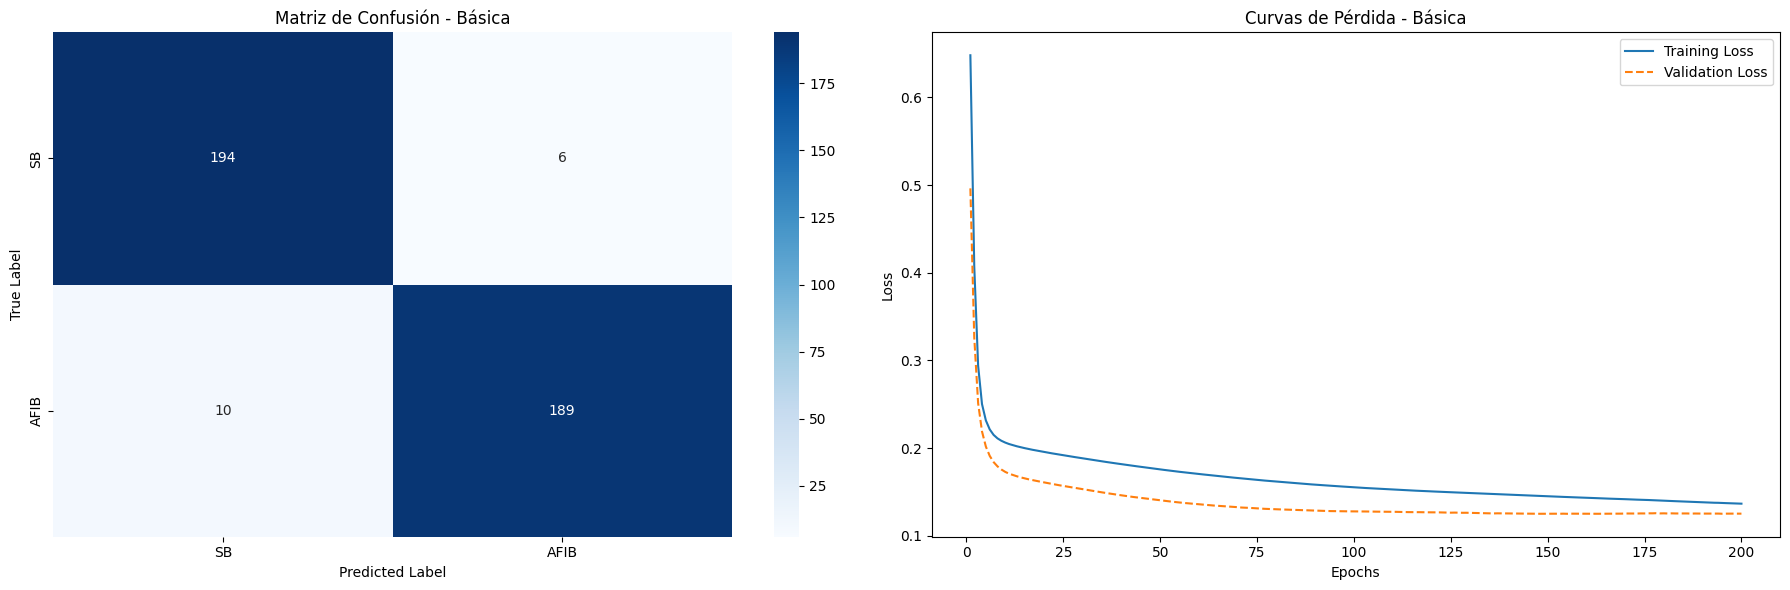


Entrenando arquitectura: Intermedia
Precisión en entrenamiento: 0.9599
Precisión en validación: 0.9574

Reporte de clasificación:
              precision    recall  f1-score   support

          SB       0.94      0.97      0.96       200
        AFIB       0.97      0.94      0.96       199

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399



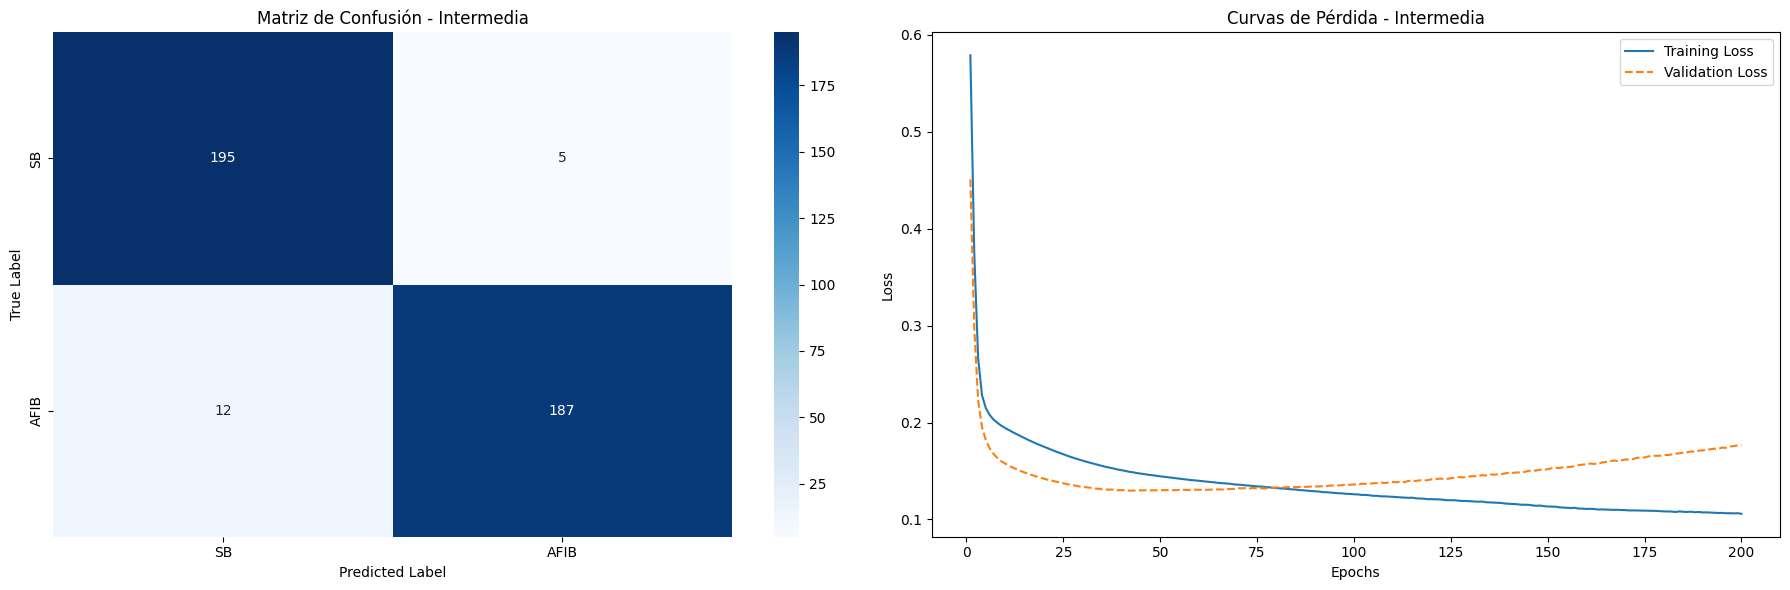


Entrenando arquitectura: Avanzada
Precisión en entrenamiento: 0.9743
Precisión en validación: 0.9474

Reporte de clasificación:
              precision    recall  f1-score   support

          SB       0.95      0.95      0.95       200
        AFIB       0.95      0.94      0.95       199

    accuracy                           0.95       399
   macro avg       0.95      0.95      0.95       399
weighted avg       0.95      0.95      0.95       399



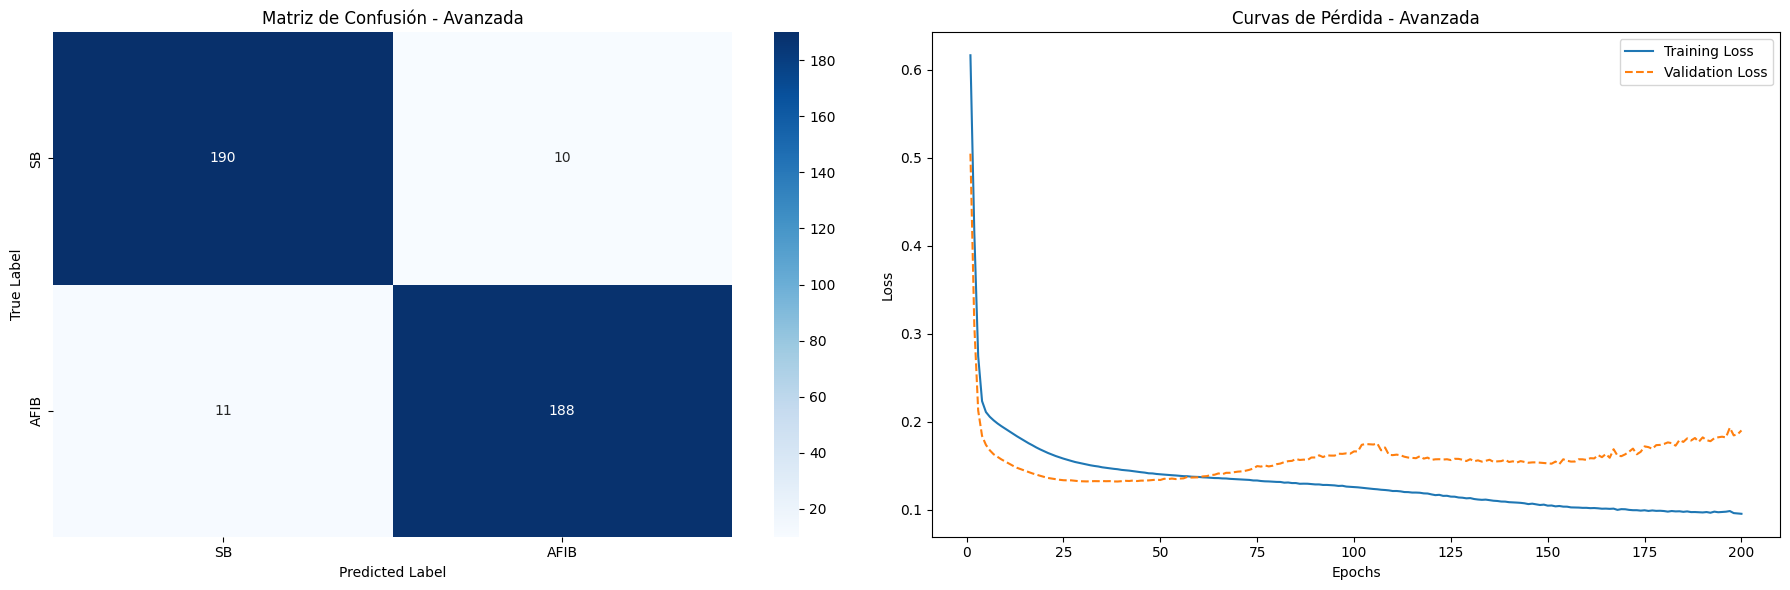

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar los warnings de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Configuración de las arquitecturas
architectures = {
    "Básica": (54,),
    "Intermedia": (54, 26),
    "Avanzada": (54, 26, 14)
}

# Configuración general del modelo
activation = 'relu'  # Función de activación
solver = 'adam'      # Algoritmo de optimización
batch_size = 64      # Tamaño de lote
learning_rate_init = 0.001  # Tasa de aprendizaje inicial
alpha = 0.0001       # Regularización L2

# Iterar sobre las diferentes arquitecturas
for name, layers in architectures.items():
    print(f"\nEntrenando arquitectura: {name}")

    # Inicializar el modelo con los parámetros proporcionados
    model = MLPClassifier(
        hidden_layer_sizes=layers,
        activation=activation,
        solver=solver,
        max_iter=1,  # Entrenamiento incremental
        random_state=42,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        batch_size=batch_size,
        warm_start=True  # Para entrenar incrementalmente
    )

    # Variables para registrar pérdidas
    train_loss_ = []
    valid_loss_ = []

    # Entrenamiento
    for epoch in range(200):  # 200 épocas
        # Entrenar el modelo en el conjunto de entrenamiento
        model.fit(X_train, y_train)

        # pérdida de entrenamiento
        train_loss_.append(model.loss_)

        # pérdida de validación
        y_pred_proba = model.predict_proba(X_test)
        valid_loss_.append(log_loss(y_test, y_pred_proba))

    # Predicciones
    y_pred = model.predict(X_test)

    # Precisión en entrenamiento y validación
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
    print(f"Precisión en validación: {test_accuracy:.4f}")

    # Reporte de clasificación
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['SB', 'AFIB']))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualizacion de la matriz de confusión y curvas de pérdida
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['SB', 'AFIB'], yticklabels=['SB', 'AFIB'], ax=axes[0])
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    axes[0].set_title(f'Matriz de Confusión - {name}')

    axes[1].plot(range(1, len(train_loss_) + 1), train_loss_, label="Training Loss")
    axes[1].plot(range(1, len(valid_loss_) + 1), valid_loss_, label="Validation Loss", linestyle='--')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"Curvas de Pérdida - {name}")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Los resultados obtenidos de los modelos con arquitecturas Básica, Intermedia y Avanzada proporcionan una visión integral sobre cómo la complejidad de la arquitectura afecta el desempeño de la red neuronal en términos de precisión, generalización y comportamiento durante el entrenamiento.

En primer lugar, el modelo con arquitectura **Básica**, que consta de una sola capa oculta con 54 neuronas, destaca por su simplicidad y desempeño consistente. Este modelo logró una precisión en entrenamiento de 0.9537 y una precisión en validación de 0.9599, lo que indica que está aprendiendo de manera efectiva los patrones clave del dataset sin sobreajustarse a los datos de entrenamiento. Las curvas de pérdida reflejan una convergencia adecuada, con una estabilidad evidente entre la pérdida de entrenamiento y validación a lo largo de las 200 épocas. Esto refuerza la idea de que el modelo captura relaciones generales en los datos sin memorizar ejemplos específicos, permitiendo una buena generalización. La matriz de confusión también apoya este desempeño, con un número bajo y equilibrado de errores (10 para la clase SB y 6 para AFIB). Por lo tanto, este modelo es confiable, eficiente y adecuado para la tarea de clasificación de ritmos cardíacos en este caso de estudio.

El modelo con arquitectura **Intermedia**, que introduce una segunda capa oculta con 26 neuronas, muestra una mayor precisión en entrenamiento (0.9599) mientras que la precisión en validación disminuye respecto a la del modelo Básico (0.9574). Este incremento en la precisión del entrenamiento refleja que el modelo tiene una capacidad ligeramente mayor para aprender patrones más complejos. Sin embargo, las curvas de pérdida muestran un sobreajuste leve: la pérdida de validación comienza a separarse de la de entrenamiento hacia las últimas épocas. A pesar de esta divergencia, la precisión en validación no se ve afectada, lo que sugiere que el sobreajuste no es suficientemente significativo como para comprometer la capacidad de generalización del modelo. La matriz de confusión refuerza esta idea, mostrando 19 errores totales, con una ligera mejora en la predicción de la clase SB (5 errores frente a 12 en AFIB). Este modelo es una opción interesante para exploraciones adicionales, ya que, a pesar de introducir mayor complejidad, logra mantener una buena capacidad de generalización.

Por otro lado, el modelo con arquitectura Avanzada, que consta de tres capas ocultas con 54, 26 y 14 neuronas, presenta un comportamiento distinto. Este modelo alcanzó la mayor precisión en entrenamiento (0.9743), pero su precisión en validación disminuyó a 0.9474, lo que indica un impacto significativo del sobreajuste. Las curvas de pérdida evidencian claramente este fenómeno: la pérdida de validación comienza a crecer después de aproximadamente 100 épocas, mientras que la pérdida de entrenamiento continúa disminuyendo. Esto sugiere que el modelo está capturando detalles específicos de los datos de entrenamiento que no son representativos de los datos de validación. La matriz de confusión refuerza esta conclusión, mostrando un incremento en los errores totales (10 para SB y 11 para AFIB). Este comportamiento refleja que, aunque el modelo Avanzado tiene una capacidad mucho mayor para aprender patrones complejos, esta capacidad no se traduce en una mejora significativa en la generalización, evidenciando que una arquitectura más compleja no es necesaria ni adecuada para este conjunto de datos y tarea de clasificación.

Un aspecto importante a destacar es la relación entre las curvas de pérdida y las métricas de validación. Tanto en el modelo Intermedio como en el Avanzado, las curvas de pérdida reflejan sobreajuste, pero la precisión en validación permanece alta. Esto se debe a que la precisión evalúa predicciones discretas (aciertos y errores) y no tiene en cuenta las probabilidades predichas que subyacen a estas decisiones. Por otro lado, la pérdida mide qué tan bien las probabilidades predichas del modelo reflejan las etiquetas verdaderas, siendo más sensible al sobreajuste. Este análisis refuerza la necesidad de interpretar los resultados considerando tanto métricas discretas como continuas, ya que cada una aporta información complementaria sobre el desempeño del modelo.

A modo de conocer mejor la implicacion de la funcion de activacion en la red neuronal, se realizan los modelos con la misma arquitectura, pero esta vez con la **función de activacion Sigmoide**, ya que se ha encontrado que esta función de activación es buena elección para modelos de clasificación binaria [36].

Esta función es útil para tareas de clasificación binaria, ya que mapea cualquier valor de entrada a un rango entre 0 y 1, interpretado como una probabilidad. Esto la hace particularmente efectiva en la capa de salida de redes neuronales para problemas donde se desea una probabilidad de pertenencia a una clase, como en este caso, la clasificación de señales ECG.


Entrenando arquitectura: Básica
Precisión en entrenamiento: 0.9405
Precisión en validación: 0.9599

Reporte de clasificación:
              precision    recall  f1-score   support

          SB       0.96      0.96      0.96       200
        AFIB       0.96      0.95      0.96       199

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399



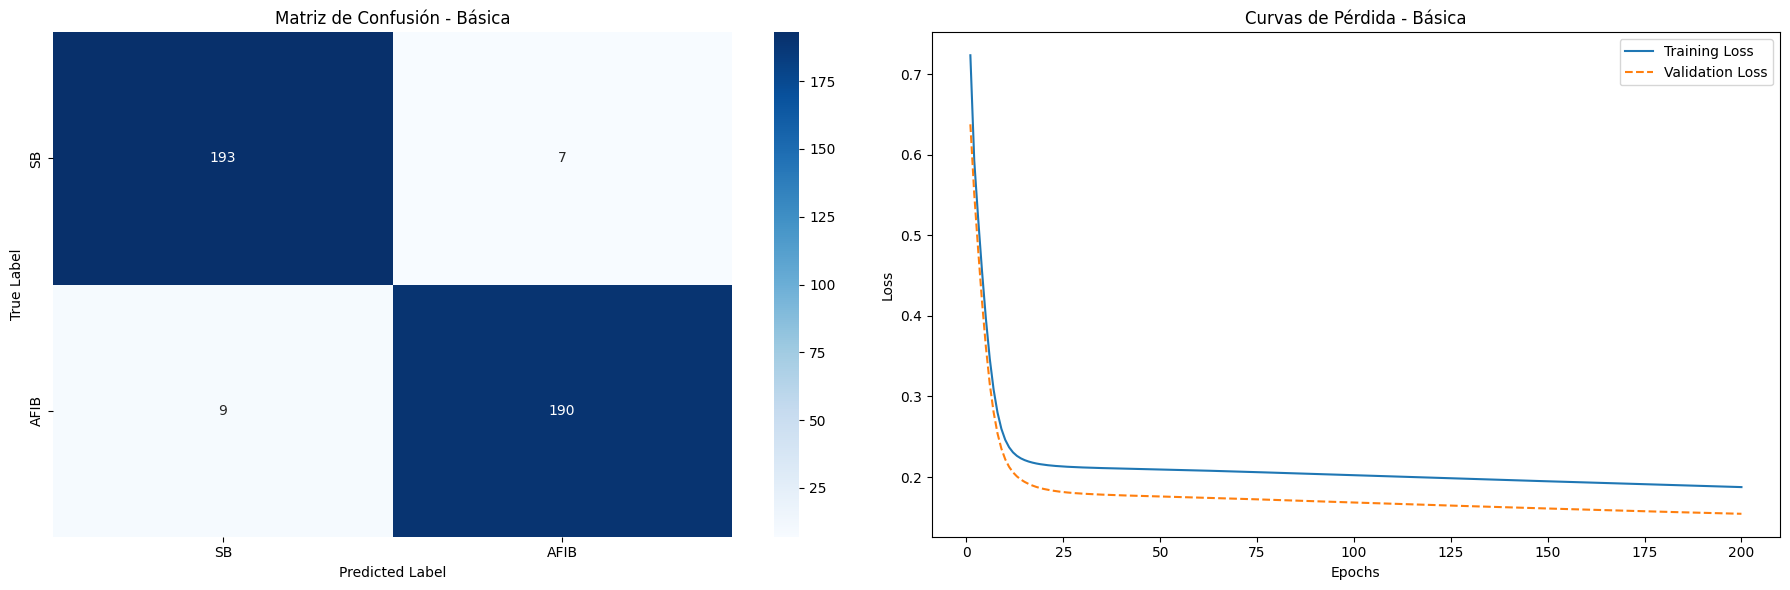


Entrenando arquitectura: Intermedia
Precisión en entrenamiento: 0.9405
Precisión en validación: 0.9624

Reporte de clasificación:
              precision    recall  f1-score   support

          SB       0.96      0.96      0.96       200
        AFIB       0.96      0.96      0.96       199

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399



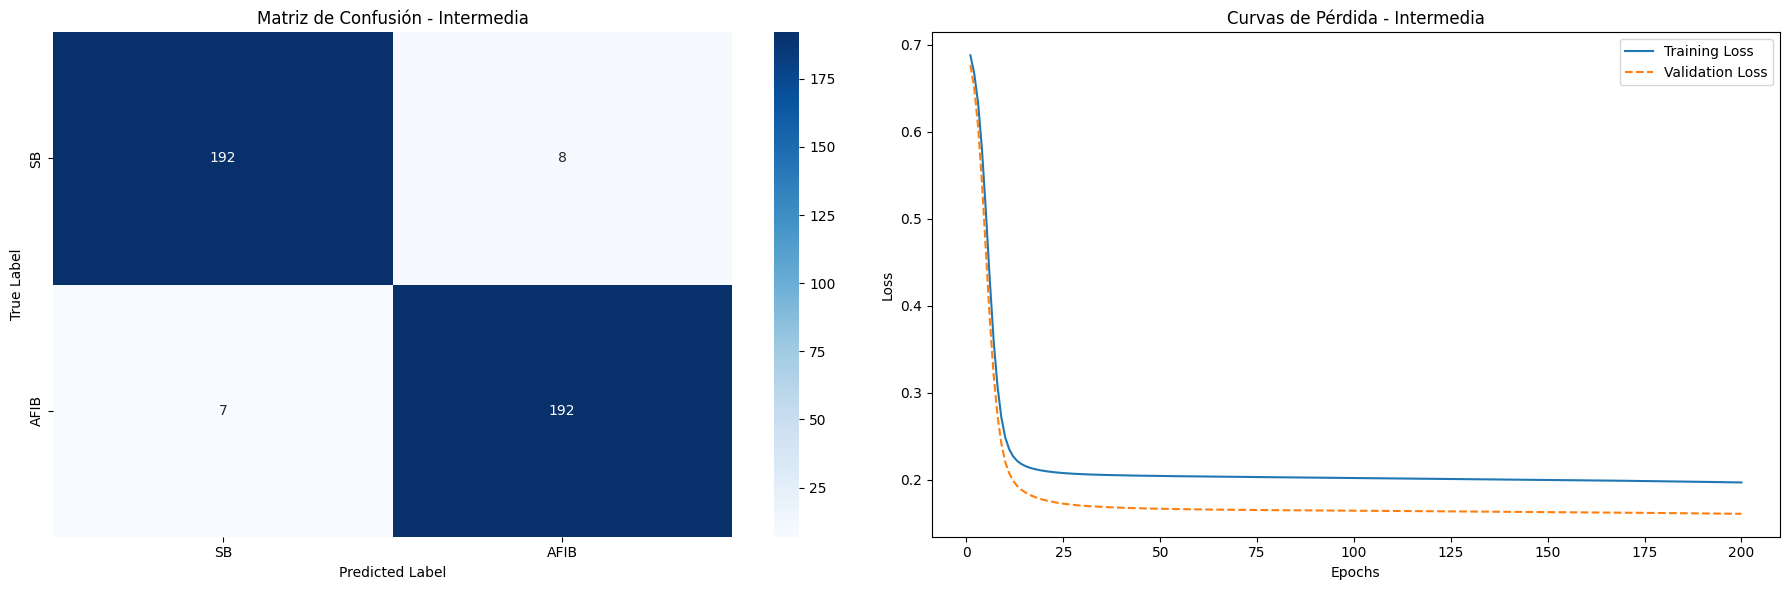


Entrenando arquitectura: Avanzada
Precisión en entrenamiento: 0.9424
Precisión en validación: 0.9599

Reporte de clasificación:
              precision    recall  f1-score   support

          SB       0.96      0.95      0.96       200
        AFIB       0.96      0.96      0.96       199

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399



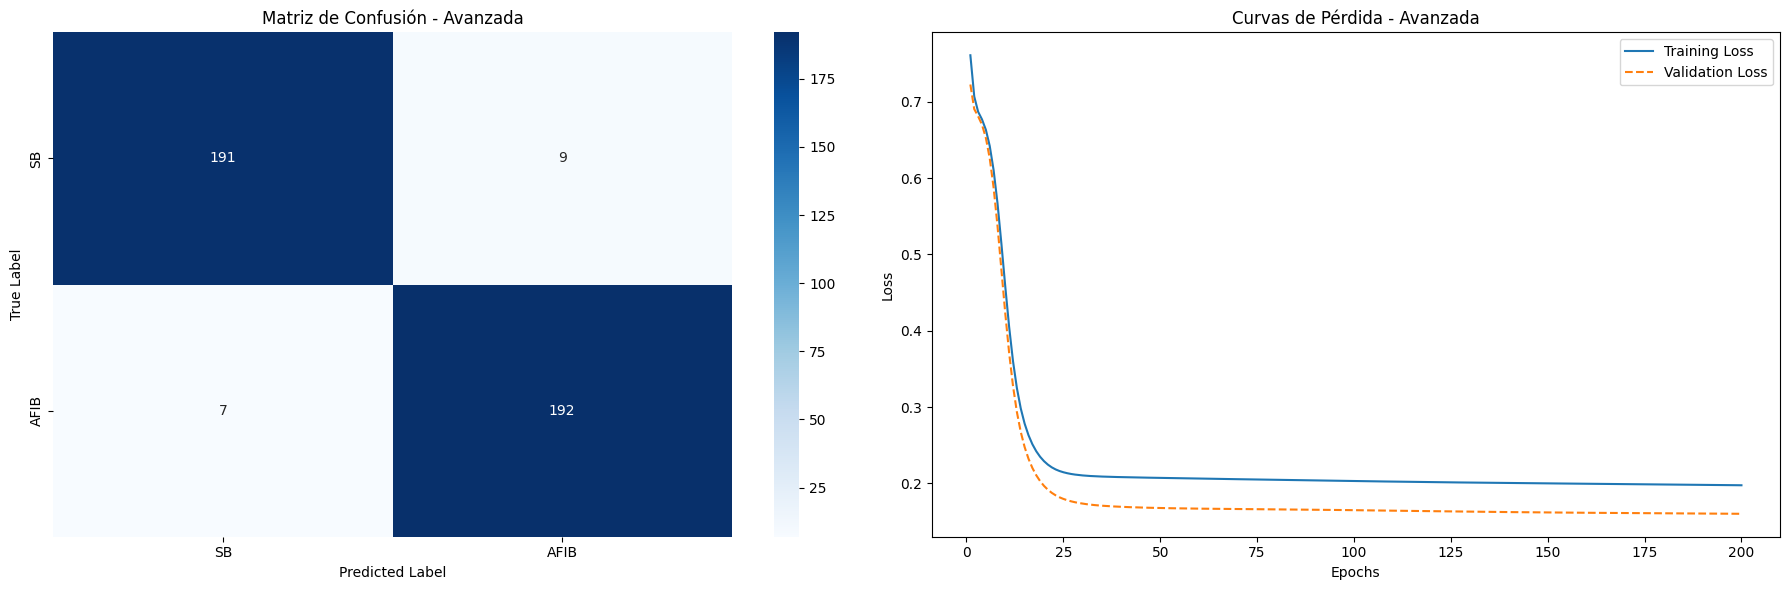

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar los warnings de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Configuración de las arquitecturas
architectures = {
    "Básica": (54,),
    "Intermedia": (54, 26),
    "Avanzada": (54, 26, 14)
}

# Configuración general del modelo
activation = 'logistic'  # Función de activación (sigmoide)
solver = 'adam'          # Algoritmo de optimización
batch_size = 64          # Tamaño de lote
learning_rate_init = 0.001  # Tasa de aprendizaje inicial
alpha = 0.0001           # Regularización L2

# Iterar sobre las diferentes arquitecturas
for name, layers in architectures.items():
    print(f"\nEntrenando arquitectura: {name}")

    # Inicializar el modelo con los parámetros proporcionados
    model = MLPClassifier(
        hidden_layer_sizes=layers,
        activation=activation,
        solver=solver,
        max_iter=1,  # Entrenamiento incremental
        random_state=42,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        batch_size=batch_size,
        warm_start=True  # Para entrenar incrementalmente
    )

    # Variables para registrar pérdidas
    train_loss_ = []
    valid_loss_ = []

    # Entrenamiento
    for epoch in range(200):  # 200 épocas
        model.fit(X_train, y_train)

        # pérdida de entrenamiento
        train_loss_.append(model.loss_)

        # pérdida de validación
        y_pred_proba = model.predict_proba(X_test)
        valid_loss_.append(log_loss(y_test, y_pred_proba))

    # Predicciones
    y_pred = model.predict(X_test)

    # Precisión en entrenamiento y validación
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
    print(f"Precisión en validación: {test_accuracy:.4f}")

    # Reporte de clasificación
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['SB', 'AFIB']))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualizacion de la matriz de confusión y curvas de pérdida
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['SB', 'AFIB'], yticklabels=['SB', 'AFIB'], ax=axes[0])
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    axes[0].set_title(f'Matriz de Confusión - {name}')

    axes[1].plot(range(1, len(train_loss_) + 1), train_loss_, label="Training Loss")
    axes[1].plot(range(1, len(valid_loss_) + 1), valid_loss_, label="Validation Loss", linestyle='--')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"Curvas de Pérdida - {name}")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Los resultados obtenidos con los modelos que utilizan la función de activación sigmoide muestran un rendimiento consistente y alto, con valores de precisión, recall y f1-score cercanos a 0.96 en configuraciones de 1, 2 y 3 capas. Esto indica que la sigmoide es una opción efectiva para este conjunto de datos y características, permitiendo una buena discriminación entre las clases (SB y AFIB). Además, la ligera mejora en el balance entre precisión y recall al aumentar la complejidad del modelo sugiere que incluso las configuraciones más simples son suficientes para este problema específico.
Las matrices de confusión refuerza estos hallazgos, mostrando un número mínimo de errores de clasificación en los modelos con sigmoide. Este bajo margen de error, junto con las curvas de pérdida estables, demuestra que la combinación de un diseño de modelo sencillo con la elección adecuada de función de activación puede proporcionar resultados robustos y evitar problemas como el sobreajuste, logrando un balance óptimo entre simplicidad y rendimiento.

En comparación con los resultados previos utilizando la función de activación ReLU, se observa que la sigmoide es más adecuada para este contexto. Mientras que ReLU mostró indicios de sobreajuste, con divergencias en las curvas de pérdida entre entrenamiento y validación, los modelos con sigmoide presentan una convergencia estable y balanceada. Esto se debe a que ReLU suele ser más efectiva en redes profundas y grandes volúmenes de datos, mientras que la sigmoide maneja mejor la generalización en conjuntos de datos más pequeños y con características limitadas.

### **8.** Consultar cómo funciona, realizar y discutir un ejemplo con los datos, del algoritmo de K means (10%) y máquinas de soporte vectorial (SVM) (10%)

<blockquote>

### **Algoritmo K means**

- ¿Qué es?

Los algoritmos de aprendizaje automático se pueden clasificar en dos categorías: aprendizaje supervisado y no supervisado. La agrupación en clústeres de K-Means es el algoritmo de aprendizaje automático no supervisado más común para agrupar puntos de datos [11].

Es un método para encontrar la estructura de un grupo en un conjunto de datos que se caracteriza por la mayor similitud dentro del mismo grupo y la mayor disimilitud entre diferentes grupos [12].

- ¿Para que sirve?

El algoritmo K-means es utilizado para la generación de señales de características. Cuando se proporciona una cantidad de muestras y se requiere agruparlas en un número K de grupos, se puede utilizar el algoritmo K-means [13].

Se utiliza ampliamente para muchas aplicaciones que incluyen: segmentación de imágenes, segmentación de clientes, agrupamiento de especies, detección de anomalías y lenguajes de agrupamiento [11].

-  ¿Cómo funciona?

En primer lugar, cada punto de datos se asigna aleatoriamente a uno de los K grupos. Luego, calculamos el centroide (funcionalmente, el centro) de cada grupo y reasignamos cada punto de datos al grupo con el centroide más cercano. Repetimos este proceso hasta que las asignaciones de grupos para cada punto de datos ya no cambien.

La agrupación en grupos de K-means requiere que seleccionemos K, la cantidad de grupos en los que queremos agrupar los datos. El método del codo (elbow)  nos permite graficar la inercia (una métrica basada en la distancia) y visualizar el punto en el que comienza a disminuir linealmente. Este punto se conoce como el "codo (elbow) " y es una buena estimación del mejor valor para K en función de nuestros datos [14].

</blockquote>

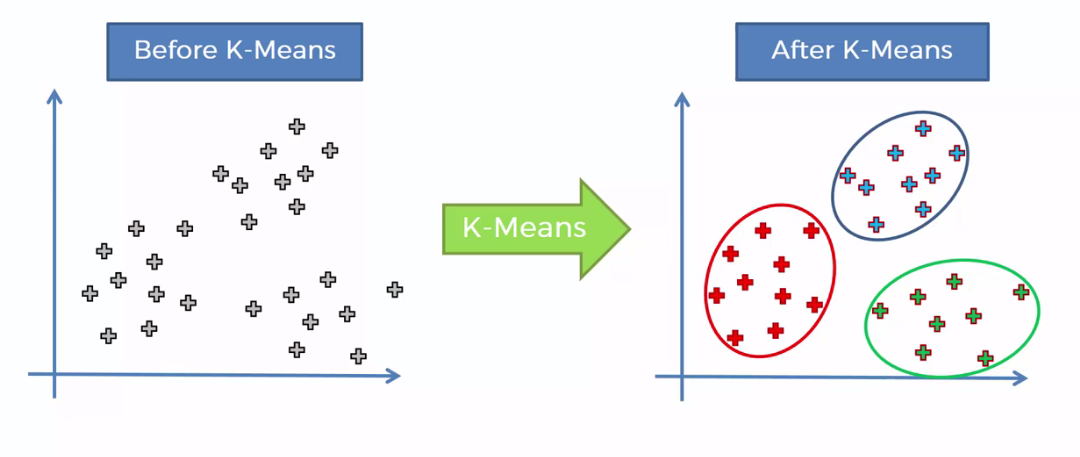

In [ ]:
#@title **Ejemplo de K means [11]**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/kmeans.png", width=700, height=300))

Se implementará el método de K-Means para realizar una agrupación de los datos en dos escenarios diferentes. En el primer caso, se utilizarán directamente las características `fMP`(Hz) (Frecuencia de Máxima Potencia) y `Heart_Rate` (Frecuencia Cardíaca) como las dimensiones para la separación de los clusters. Estas dos variables son una excelente elección, ya que capturan información importante del comportamiento fisiológico de los ritmos cardíacos y son representativas de las diferencias entre las clases SB (Bradicardia Sinusal) y AFIB (Fibrilación Auricular).

En el segundo caso, se aplicará el método de Análisis de Componentes Principales (PCA) para reducir la dimensionalidad del conjunto de datos completo. Esto permitirá proyectar todas las características disponibles en un espacio bidimensional, capturando la mayor variabilidad de los datos en dos componentes principales [30]. Esta técnica ayuda a identificar patrones globales en el dataset al combinar linealmente las características originales, lo que puede proporcionar una visión más representativa de la separación de los clusters en el espacio reducido.

Coeficiente de Silueta: 0.4235

Tabulación cruzada entre Clusters y Estado:
Cluster    0    1
Estado           
0        974   26
1        234  762


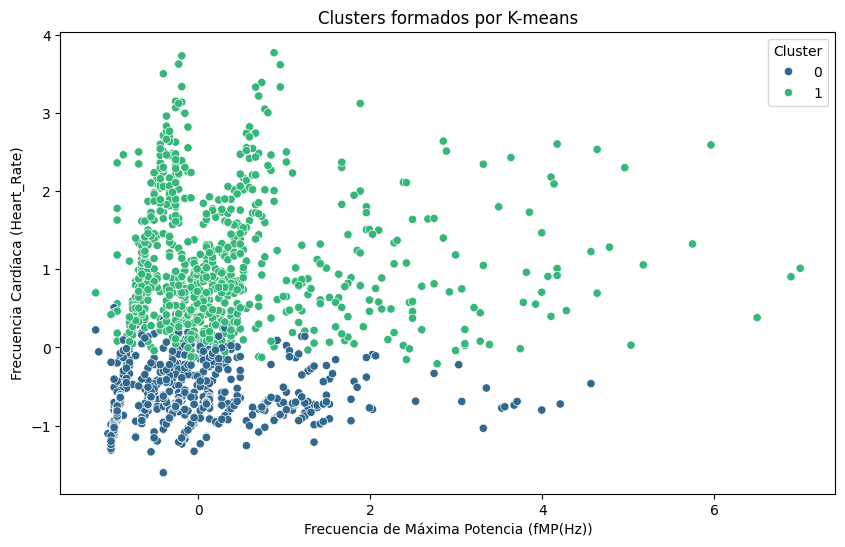

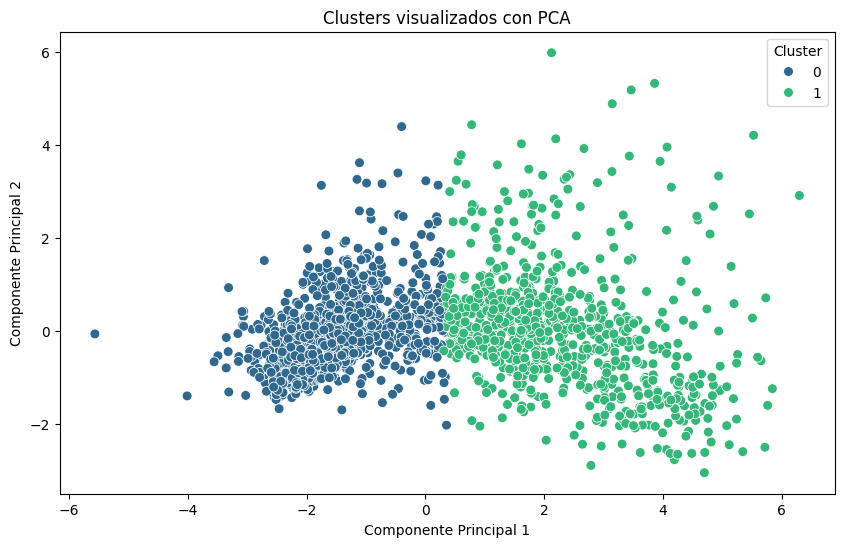

Edad  Sexo   fMP(Hz)  Estado  Heart_Rate   R_Peaks   P_Peaks  \
0     1.290534     0  1.953570       1    1.506104  1.596322  2.288904   
1    -0.476345     1 -0.336194       0   -0.913823 -0.988782 -1.007382   
2     0.543008     0  0.272024       0   -0.577744 -0.518763 -0.274874   
3    -0.340431     0 -0.228862       0   -0.671689 -0.518763 -0.274874   
4     1.018706     0  2.204012       1    0.100014  0.186265  0.823888   
...        ...   ...       ...     ...         ...       ...       ...   
1991  1.018706     1 -0.085751       1   -0.227352 -0.048744  0.457634   
1992 -1.291828     0 -0.586637       0   -0.730454 -0.753773 -0.641128   
1993 -0.680216     1 -0.264639       0   -0.756239 -0.753773 -0.641128   
1994 -0.748173     1  4.207556       0   -0.724101 -0.753773 -0.641128   
1995  0.271181     0 -0.336194       1    0.665760  0.656284  1.556396   

      Phase_Vent       HRV  Cluster  
0      -0.478399 -1.441948        1  
1      -0.487356  1.140406        0  
2       0.470785  0.566943        0  
3      -0.435662  0.617420        0  
4      -0.817931 -0.439274        1  
...          ...       ...      ...  
1991   -1.484534 -0.064622        0  
1992   -0.611215  0.730661        0  
1993   -0.217420  0.782466        0  
1994   -1.118219  0.714721        0  
1995    0.008590 -0.903338        1  

[1996 rows x 10 columns]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seleccionar las características para el clustering
X = df_final.drop(columns=['Estado'])

# Inicializar el modelo KMeans
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(X)

# tiquetas de los clusters
labels = kmeans.labels_

# Agregar las etiquetas
df_final['Cluster'] = labels

# coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)
print(f"Coeficiente de Silueta: {silhouette_avg:.4f}")

# Tabulación cruzada entre Clusters y Estado
cross_tab = pd.crosstab(df_final['Estado'], df_final['Cluster'], rownames=['Estado'], colnames=['Cluster'])
print("\nTabulación cruzada entre Clusters y Estado:")
print(cross_tab)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='fMP(Hz)', y='Heart_Rate', hue='Cluster', palette='viridis')
plt.title('Clusters formados por K-means')
plt.xlabel('Frecuencia de Máxima Potencia (fMP(Hz))')
plt.ylabel('Frecuencia Cardíaca (Heart_Rate)')
plt.legend(title='Cluster')
plt.show()

# clusters con PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=50)
plt.title('Clusters visualizados con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

df_final

El análisis de los resultados obtenidos con el algoritmo K-Means muestra una separación moderada entre los clusters generados, como lo refleja el coeficiente de silueta de 0.4449. Este valor sugiere que el agrupamiento captura ciertos patrones subyacentes en los datos, aunque no de forma completamente clara. Al observar la tabulación cruzada, se evidencia que el Cluster 0 agrupa principalmente registros con `Estado=1` (AFIB), mientras que el Cluster 1 se asocia mayormente con `Estado=0` (SB). Sin embargo, la mezcla significativa entre las clases dentro de cada cluster indica que la separación no es perfecta. Este comportamiento refleja la naturaleza compleja de los datos, donde las características compartidas entre clases dificultan una clasificación clara mediante un algoritmo no supervisado como K-Means.

En cuanto a las visualizaciones, el gráfico que utiliza las variables fMP(Hz) y Heart_Rate muestra una separación parcial entre los clusters, aunque con una notable superposición en los valores más cercanos al origen. Por otro lado, el uso de PCA permite observar los clusters en un espacio de menor dimensionalidad donde parecen más separados, lo que sugiere que combinaciones lineales de las características originales pueden ser más efectivas para diferenciar los grupos. Sin embargo, la superposición persiste, lo que es coherente con el coeficiente de silueta moderado y con la tabulación cruzada.

En general, el modelo K-Means logra identificar patrones útiles en los datos, pero su capacidad para separar completamente las clases es limitada. Esto podría atribuirse a la naturaleza no lineal o correlacionada de las características y a las limitaciones propias de K-Means para trabajar con muchos datos no lineales.

<blockquote>

### **Máquina de soporte vectorial (SVM)**

* ¿Qué es?

Una máquina de vectores de soporte (SVM) es un potente algoritmo de aprendizaje automático ampliamente utilizado tanto para la clasificación lineal como para la no lineal , así como para tareas de regresión y detección de valores atípicos [16].

El objetivo del algoritmo SVM es crear la mejor línea o límite de decisión que pueda segregar el espacio n-dimensional en clases para que podamos colocar fácilmente el nuevo punto de datos en la categoría correcta en el futuro. Este mejor límite de decisión se denomina hiperplano. SVM elige los puntos/vectores extremos que ayudan a crear el hiperplano. Estos casos extremos se denominan vectores de soporte y, por lo tanto, el algoritmo se denomina máquina de vectores de soporte [17].

* ¿Para que sirve?

Las SVM son altamente adaptables, lo que las hace adecuadas para diversas aplicaciones, como la clasificación de texto , la clasificación de imágenes , la detección de spam , la identificación de escritura a mano , el análisis de expresión genética , la detección de rostros y la detección de anomalías [16].

  Las SVM son uno de los algoritmos de aprendizaje automático más populares porque son muy eficaces en una variedad de tareas, entre ellas [18]:

    - Clasificación : las máquinas de clasificación de datos se pueden utilizar para clasificar datos en dos o más categorías. Por ejemplo, se pueden utilizar para clasificar imágenes como gatos o perros, o para clasificar texto como spam o correo basura [18].

    - Regresión : las SVM se pueden utilizar para predecir un valor continuo, como el precio de una casa o la cantidad de ventas que generará un producto [18].

    - Detección de valores atípicos : las SVM se pueden utilizar para identificar valores atípicos, que son puntos de datos que son significativamente diferentes del resto de los datos [18].

* ¿Cómo funciona?

El SVM funciona asignando datos a un espacio de características de alta dimensión para que los puntos de datos se puedan categorizar, incluso cuando los datos no se puedan separar linealmente de otra manera. Se encuentra un separador entre las categorías y luego los datos se transforman de tal manera que el separador se pueda dibujar como un hiperplano. A continuación, se pueden utilizar las características de los nuevos datos para predecir el grupo al que debe pertenecer un nuevo registro [19].

* Tipos de máquinas de soporte vectorial

Las máquinas de vectores de soporte se clasifican en dos tipos: SVM simple o lineal y SVM de núcleo o no lineal [20].

    1. Simple o lineal: Un SVM lineal se refiere al tipo de SVM utilizado para clasificar datos linealmente separables. Esto implica que cuando un conjunto de datos se puede separar en categorías o clases con la ayuda de una sola línea recta, se denomina SVM lineal y los datos se denominan linealmente distintos o separables. Normalmente se utiliza un SVM simple para abordar problemas de clasificación y análisis de regresión [20].

    2. De núcleo o no lineal: Los datos no lineales que no se pueden separar en categorías distintas con la ayuda de una línea recta se clasifican utilizando un kernel o SVM no lineal. Aquí, el clasificador se denomina clasificador no lineal. La clasificación se puede realizar con un tipo de datos no lineal agregando características en dimensiones superiores en lugar de depender del espacio 2D. Aquí, las características recién agregadas se ajustan a un hiperplano que ayuda a separar fácilmente las clases o categorías. Las SVM de kernel se utilizan normalmente para manejar problemas de optimización que tienen múltiples variables [20].

</blockquote>

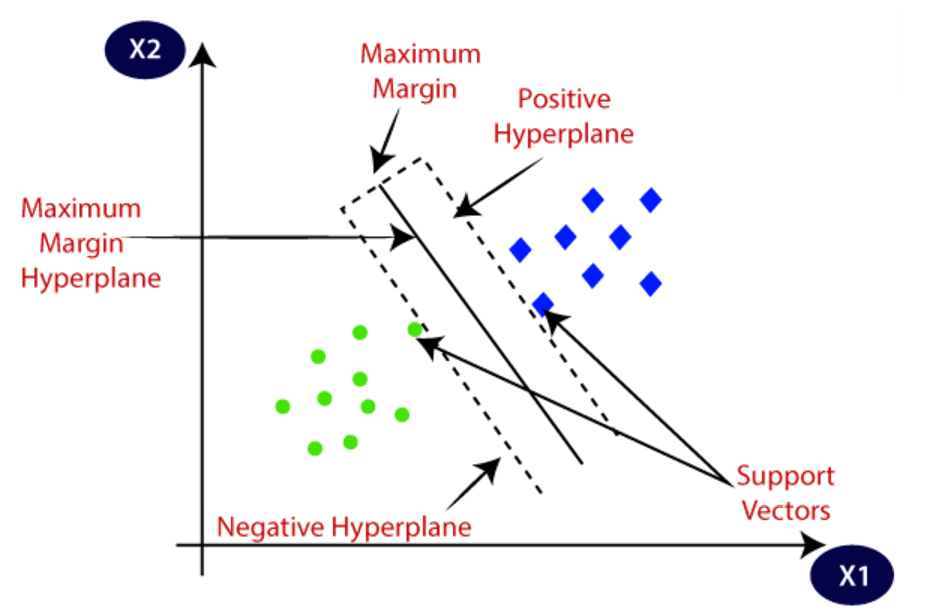

In [ ]:
#@title **Ejemplo de SVM [17]**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/svm.png", width=500, height=400))

Informe de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

          SB       0.89      0.95      0.92       800
        AFIB       0.95      0.88      0.91       797

    accuracy                           0.92      1597
   macro avg       0.92      0.92      0.92      1597
weighted avg       0.92      0.92      0.92      1597

Informe de clasificación para el conjunto de validacion:
              precision    recall  f1-score   support

          SB       0.92      0.94      0.93       200
        AFIB       0.94      0.92      0.93       199

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399



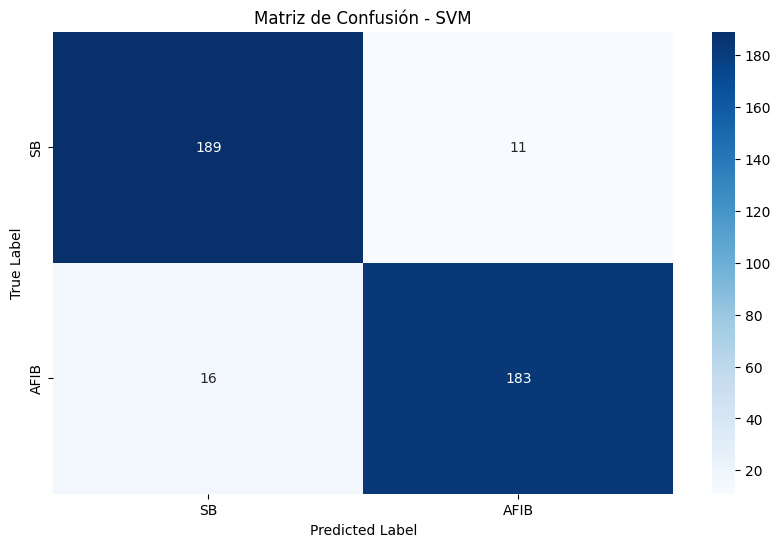

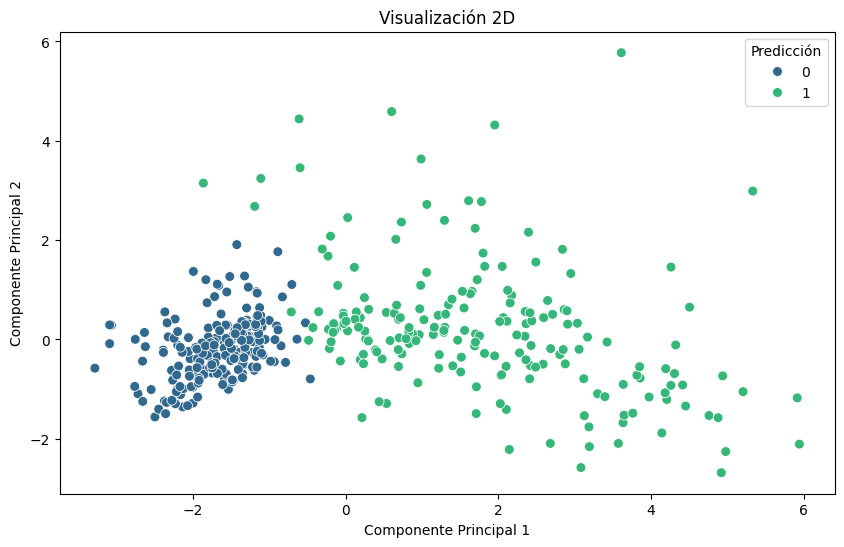

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

# se define el modelo
clf = svm.NuSVC(gamma='auto')

# se entrena el modelo
clf.fit(X_train, y_train)

# predicciones en el conjunto de entrenamiento
predict_train = clf.predict(X_train)

# predicciones en el conjunto de prueba
predict_test = clf.predict(X_test)

# nombres de las clases
target_names = ['SB', 'AFIB']

# se evalua el modelo en el conjunto de entrenamiento
print("Informe de clasificación para el conjunto de entrenamiento:")
print(classification_report(y_train, predict_train, target_names=target_names))

# se evalua el modelo en el conjunto de validacion
print("Informe de clasificación para el conjunto de validacion:")
print(classification_report(y_test, predict_test, target_names=target_names))
import matplotlib.pyplot as plt

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, predict_test)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión - SVM')
plt.show()

# Visualización 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=predict_test, palette='viridis', s=50)
plt.title('Visualización 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Predicción')
plt.show()

La implementación del modelo SVM NuSVC ha mostrado resultados consistentes y efectivos tanto en el conjunto de entrenamiento como en el de validación, con una precisión global de 0.93 y 0.92 respectivamente. Esto indica que el modelo tiene un buen equilibrio entre la capacidad de aprender patrones del conjunto de entrenamiento y la generalización en datos no vistos. En el conjunto de entrenamiento, la clase SB presenta una precisión del 90% y un recall del 96%, mientras que la clase AFIB logra una precisión del 96% pero con un recall del 89%. Esto sugiere que el modelo tiene un ligero sesgo hacia la clase SB en el entrenamiento, posiblemente debido a las características intrínsecas de los datos. En el conjunto de validación, se mantiene una precisión elevada, con un desempeño balanceado entre ambas clases: la clase SB mantiene una precisión del 90% y un recall del 94%, mientras que la clase AFIB alcanza una precisión del 94% y un recall del 90%. Las matrices de confusión refuerzan este análisis, mostrando que los errores están distribuidos de manera razonable entre las clases, lo que refleja que el modelo es confiable para la tarea de clasificación.

La visualización en 2D utilizando PCA muestra una separación clara entre las dos clases, lo que refuerza la efectividad del modelo para distinguir entre los patrones presentes en los datos. Sin embargo, los puntos mal clasificados se concentran en regiones donde las clases se solapan, lo que es esperado en problemas con características complejas y solapamiento parcial de los datos.

<blockquote>

### **Algoritmo K-Fold** (Se realiza con el fin de comparar este algoritmo con los empleados anteriormente, como nos aconsejaron las profes)

* ¿Qué es?

La validación cruzada de K-Fold es un procedimiento de remuestreo que se utiliza para evaluar modelos de aprendizaje automático en una muestra de datos limitada [22].

Implica dividir los datos disponibles en varios conjuntos o subconjuntos, utilizar uno de estos conjuntos como conjunto de validación y entrenar el modelo con los conjuntos restantes. Este proceso se repite varias veces, cada vez utilizando un conjunto diferente como conjunto de validación. Por último, se promedian los resultados de cada paso de validación para producir una estimación más sólida del rendimiento del modelo [23].

* ¿Para que sirve?

El objetivo principal de la validación cruzada es evitar el sobreajuste , que se produce cuando un modelo se entrena demasiado bien con los datos de entrenamiento y su rendimiento es deficiente con datos nuevos e inéditos. Al evaluar el modelo con varios conjuntos de validación, la validación cruzada proporciona una estimación más realista del rendimiento de generalización del modelo, es decir, su capacidad para funcionar bien con datos nuevos e inéditos [23].

* Tipos de validación cruzada K - Fold

Existen varios tipos de técnicas de validación cruzada, entre las que se incluyen la validación cruzada de k-fold, la validación cruzada de dejar uno fuera, la validación de retención y la validación cruzada estratificada. La elección de la técnica depende del tamaño y la naturaleza de los datos, así como de los requisitos específicos del problema de modelado [23].

* ¿Cómo funciona?

El algoritmo K-Fold Cross-Validation comienza mezclando aleatoriamente los datos y definiendo el valor de K, que determina el número de particiones y las iteraciones del proceso. En cada iteración, una partición se deja como conjunto de prueba (fold oculto), mientras que las K-1 particiones restantes se usan para entrenar el modelo. Posteriormente, se evalúa el desempeño tanto en el conjunto de prueba como en el de entrenamiento, almacenando los resultados. Este proceso se repite para cada partición, cambiando la que actúa como prueba. Al finalizar las K iteraciones, el desempeño general del modelo se calcula promediando las métricas obtenidas en todas las pruebas [24].

</blockquote>

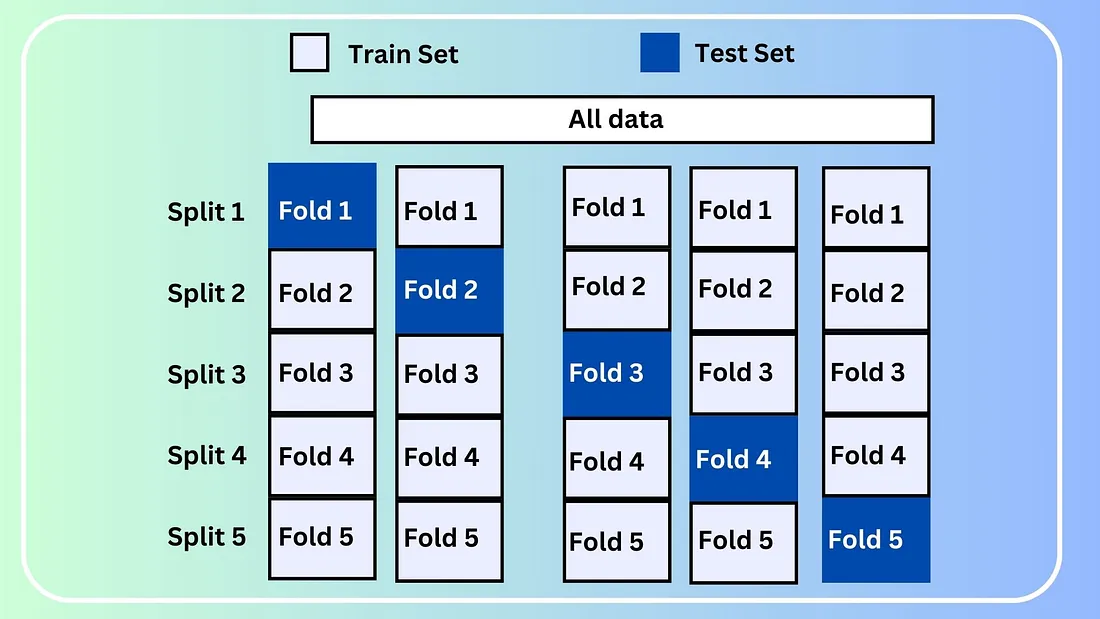

In [ ]:
#@title **Ejemplo de K - Fold [22]**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/kfold.png", width=700, height=400))

Fold 1 Accuracy: 0.9325
Matriz de Confusión para Fold 1:


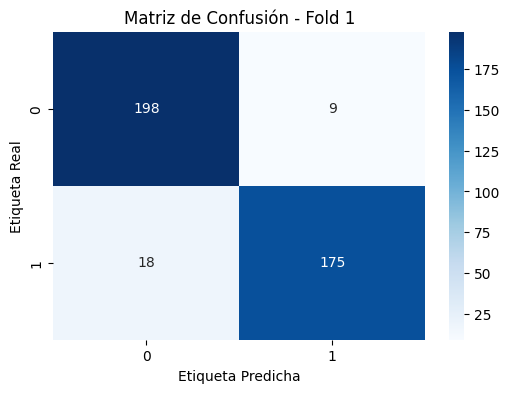

Fold 2 Accuracy: 0.9248
Matriz de Confusión para Fold 2:


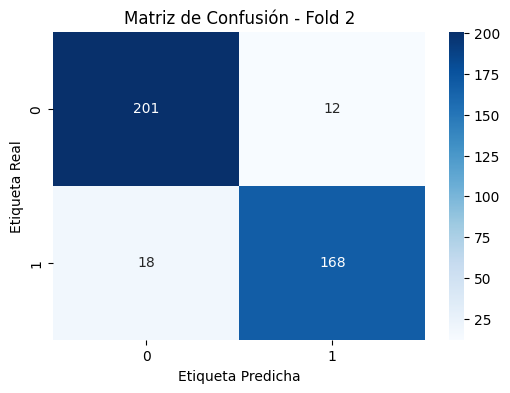

Fold 3 Accuracy: 0.8997
Matriz de Confusión para Fold 3:


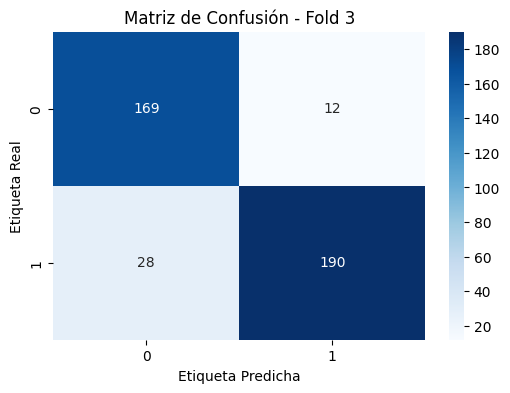

Fold 4 Accuracy: 0.9198
Matriz de Confusión para Fold 4:


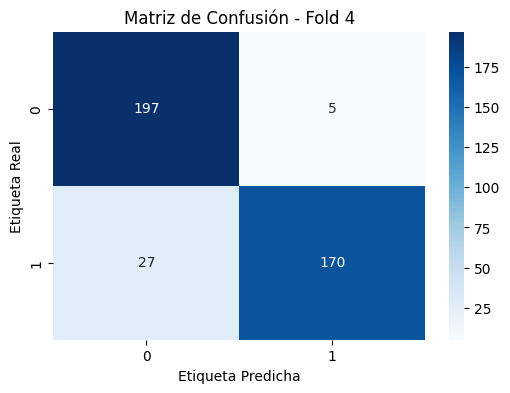

Fold 5 Accuracy: 0.9248
Matriz de Confusión para Fold 5:


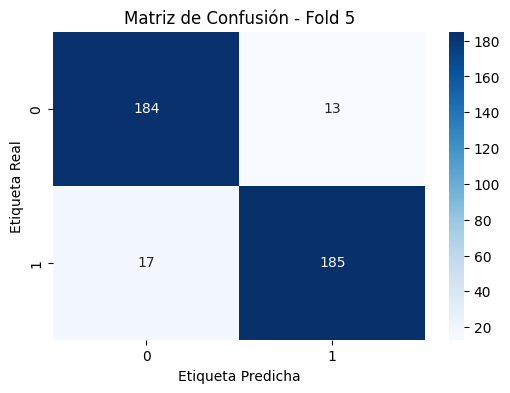


Promedio de precisión en K-Fold: 0.9203


In [ ]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
clf = svm.NuSVC(gamma='auto')

# Dividir las características y etiquetas
X = df_final.drop(columns=['Estado', 'Cluster'])  # Ajusta según las columnas de tu DataFrame
y = df_final['Estado']

# Almacenar los resultados
fold_accuracies = []

# Iterar sobre los folds
fold_number = 1
for train_index, test_index in kf.split(X):
    # Dividir los datos en train y test para este fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenar el modelo
    clf.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = clf.predict(X_test)

    # Evaluar la precisión del fold actual
    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)

    # Mostrar los resultados del fold actual
    print(f"Fold {fold_number} Accuracy: {fold_accuracy:.4f}")

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Matriz de Confusión para Fold {fold_number}:")

    # Graficar la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title(f'Matriz de Confusión - Fold {fold_number}')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Real')
    plt.show()

    fold_number += 1

# Promedio de las precisiones de los folds
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nPromedio de precisión en K-Fold: {avg_accuracy:.4f}")


El promedio de precisión en K-Fold de 0.9203, obtenido mediante la validación cruzada con K-Fold, indica que el modelo tiene un buen rendimiento en la clasificación. Este valor refleja que, en promedio, el modelo ha clasificado correctamente aproximadamente el 92% de las muestras en las diferentes particiones del conjunto de datos.


### **9.** Hacer un informe con todos los puntos anteriores (10%). En el informe incluir: Consultar por lo menos tres equipos comerciales traen ya incorporados algoritmos de ayuda diagnóstica a partir de señales EKG (5%) y discutir brevemente las funcionalidades desde la teoría vista en el curso (5%)

A continuación, se presentan dispositivos médicos habilitados para inteligencia artificial y aprendizaje automático (IA/ML) aprobados por la FDA [31].

### **Aplicaciones**

<blockquote>

**1. LINQ II™ insertable cardiac monitor by Medtronic**

Es un dispositivo médico avanzado diseñado para monitorear condiciones cardíacas mediante el uso de inteligencia artificial (IA) y aprendizaje profundo. Sus principales características incluyen [32]:

- El sistema utiliza los algoritmos AccuRhythm AI, que aplican técnicas de aprendizaje profundo para mejorar la precisión en la detección de arritmias y reducir falsos positivos en los datos transmitidos a la red CareLink™. Este flujo continuo de datos permite un monitoreo eficiente y preciso, especialmente para condiciones con síntomas poco frecuentes.

- Incluye un algoritmo específico para la detección de contracciones ventriculares prematuras (PVC), mejorando la identificación de patrones en ECG complejos. Este avance optimiza el diagnóstico y la gestión de arritmias.

- Es el primer ICM con capacidad de programación remota completa y una duración de batería de hasta 4.5 años, lo que lo hace ideal para el monitoreo a largo plazo de pacientes.

- Es el primer monitor cardíaco insertable aprobado para uso en pacientes pediátricos desde los dos años de edad, expandiendo su utilidad clínica a una población más joven.

Los algoritmos AccuRhythm™ del LINQ II™ ICM utilizan aprendizaje profundo para optimizar la detección de patologías cardíacas, lo que se relaciona directamente con los principios de análisis y procesamiento de señales estudiados en el curso. Estas técnicas permiten una clasificación precisa de eventos cardíacos, reduciendo falsos positivos y facilitando un diagnóstico más eficiente, demostrando cómo las tecnologías avanzadas pueden integrar procesamiento de datos biomédicos con inteligencia artificial para mejorar la atención médica [32].

</blockquote>

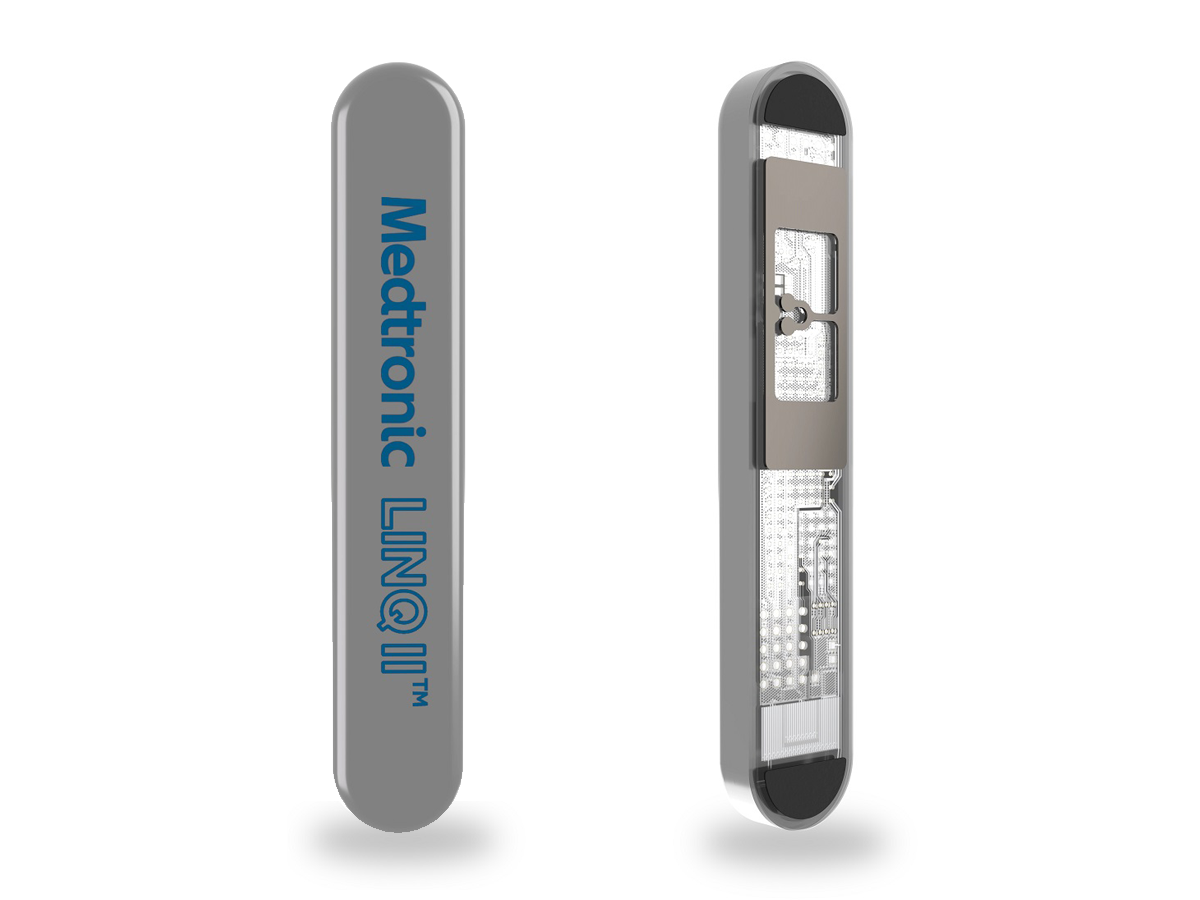

In [ ]:
#@title **LINQ II™ insertable cardiac monitor**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/DM1.png", width=500, height=400))

<blockquote>

**2. AusculThing ACC**

Es un software avanzado diseñado para profesionales de la salud, que utiliza algoritmos de inteligencia artificial para analizar sonidos cardíacos registrados mediante un estetoscopio electrónico, como el Thinklabs One. Su función principal es detectar soplos cardíacos de cualquier intensidad en diversas áreas del precordio, clasificando los sonidos en "anormales" o "normales" [33].

 El AusculThing ACC aplica técnicas de procesamiento de señales digitales para capturar y analizar las ondas sonoras del corazón. Utiliza algoritmos de aprendizaje profundo entrenados con una amplia base de datos de ecocardiogramas de alta calidad, lo que le permite identificar patrones asociados a patologías cardíacas.  Esta metodología se alinea con los principios estudiados en el curso, donde se emplearon técnicas de filtrado, análisis espectral y clasificación de señales patológicas [33].


</blockquote>

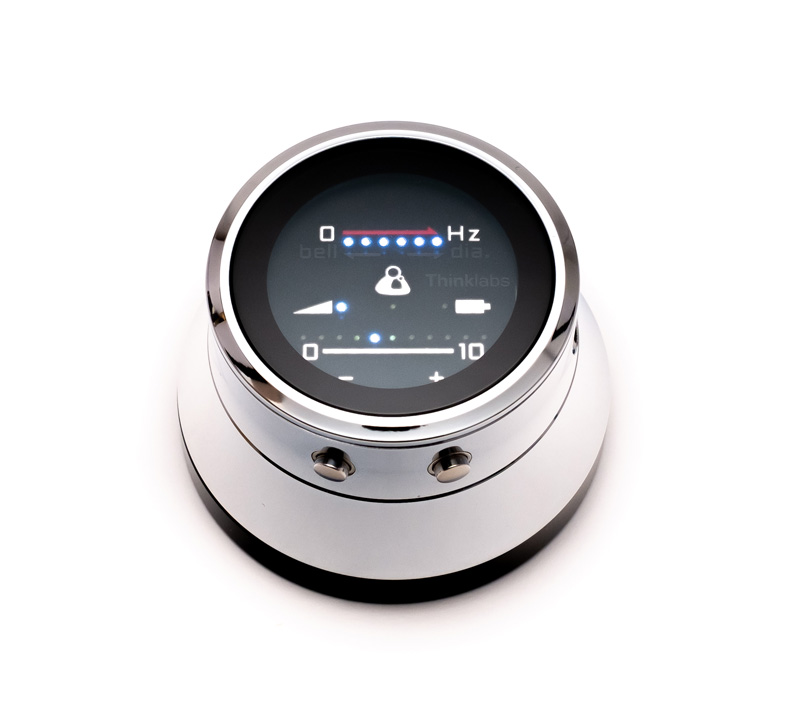

In [ ]:
#@title **AusculThing ACC**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/DM2.jpg", width=500, height=400))

<blockquote>

**3. VX1+ by Volta medical**

Es un dispositivo avanzado que utiliza algoritmos de inteligencia artificial para apoyar la ablación guiada por electrogramas (EGM) en pacientes con fibrilación auricular (FA) persistente. Emplea aprendizaje profundo para identificar regiones específicas de interés en los mapas anatómicos y eléctricos 3D del corazón, lo que facilita la identificación de electrogramas anormales, como los dispersos, en tiempo real [34].

Se relaciona con el curso, con los principios de procesamiento de señales y aprendizaje automático vistos. Utiliza algoritmos de IA, específicamente de aprendizaje profundo, para analizar en tiempo real los electrogramas (EGM) durante procedimientos de ablación cardíaca. Esto implica el uso de técnicas de filtrado para limpiar las señales y detección de patrones para identificar anomalías específicas, como los electrogramas dispersos, lo que facilita la identificación de áreas críticas para la ablación. Este proceso se alinea con los conceptos de análisis de señales, donde se aplican transformaciones y métodos matemáticos para extraer información relevante de las señales [34].

</blockquote>

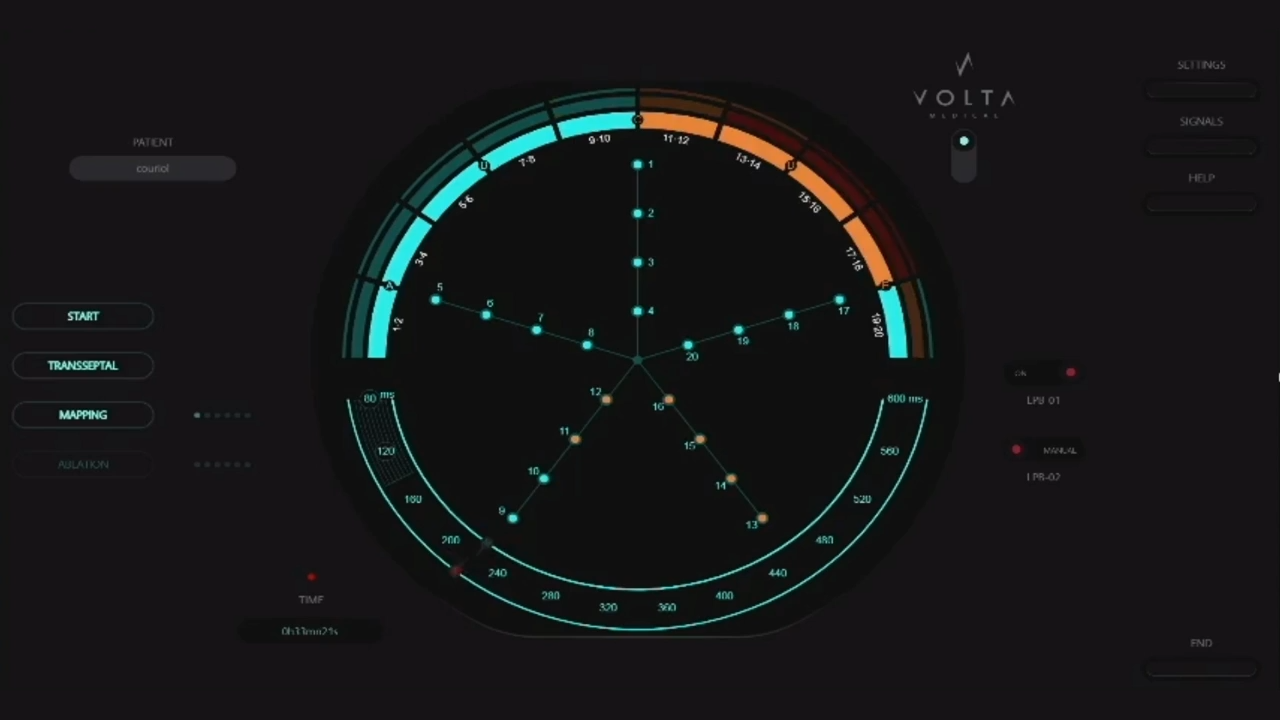

In [ ]:
#@title **VX1+**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/DM3.png", width=700, height=400))

<blockquote>

**4. Función de notificación de ritmo irregular (IRNF) by Apple Inc.**

Es una aplicación médica móvil que analiza los datos del ritmo cardíaco para identificar episodios de ritmos irregulares sugerentes de fibrilación auricular (FA). Cuando se detecta un posible episodio de FA, la función envía una notificación al usuario [35].

Esta función utiliza conceptos clave de procesamiento de señales biomédicas, como el análisis de señales ECG para detectar patrones irregulares. Los algoritmos involucrados en este proceso aplican técnicas de filtrado y análisis de patrones, similares a las que hemos estudiado, y son fundamentales para proporcionar alertas confiables y oportunas de posibles afecciones cardíacas, como la fibrilación auricular [35].


</blockquote>

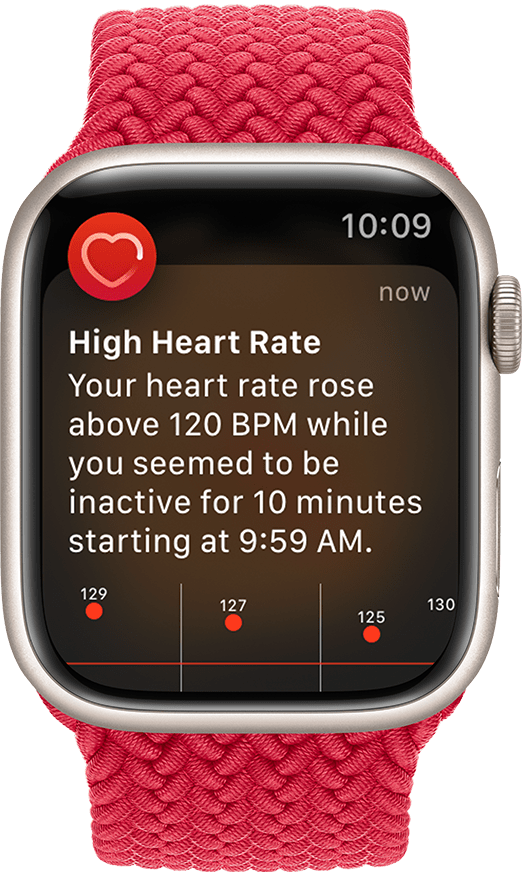

In [ ]:
#@title **IRNF**
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab_Notebooks/DM4.png", width=190, height=300))

### **Conclusiones**

* Es importante considerar que, debido a la complejidad de las señales cardíacas, es esencial aplicar algoritmos que unifiquen la escala de amplitud entre diferentes patologías, como bradicardia sinusal y fibrilación auricular, las cuales distorsionan la morfología del ECG. Esto garantiza consistencia y precisión en la clasificación de arritmias. En este proyecto, se emplearon técnicas de compresión (normalización) y detrend, para eliminar tendencias no deseadas y preservar las características esenciales de la señal para su análisis.

* Utilizar la FFT para analizar la frecuencia de máxima potencia en las señales ECG fue de más utilidad en este proyecto debido a su capacidad para procesar la señal completa sin segmentación ni promediado, porque nos permitió obtener una detección más precisa de los picos dominantes, lo cual es crucial en señales complejas como las de fibrilación auricular (AFIB), donde la claridad y resolución espectral son esenciales. A diferencia del periodograma de Welch, que puede diluir componentes importantes al promediar entre segmentos y generar ruido adicional, la FFT nos proporcionó una herramienta más eficiente para asegurar la exactitud y fiabilidad en la interpretación de los resultados.

* En cuanto a la selección de la características, se tomaron características principales que permiten identificar patrones anormales en la frecuencia cardíaca, la presencia de ondas P, la variabilidad de la frecuencia cardíaca y alteraciones en la conducción ventricular, lo que facilita la detección temprana de afecciones cardíacas y mejora la precisión en el análisis de señales ECG.

* Gracias a la realizacion de este proyecto se puede concluir que los resultados obtenidos destacan que la elección de la función de activación tiene un impacto significativo en el rendimiento de las redes neuronales. En este proyecto, la función sigmoide demostró ser más adecuada que ReLU para el análisis de señales ECG en un conjunto de datos relativamente pequeño y específico, como el empleado para clasificar ritmos cardíacos (SB y AFIB). La sigmoide logró un balance sólido entre precisión, recall y f1-score, mientras que ReLU presentó indicios de sobreajuste. Esto subraya la necesidad de adaptar las configuraciones de los modelos a las características particulares del problema y el tamaño del conjunto de datos.

* Respecto a los algoritmos K-means, Máquinas de Soporte Vectorial (SVM) y K-Folds tienen ventajas distintas en la clasificación de señales ECG. Mientras que K-means es útil para agrupar datos no etiquetados, SVM destaca en la clasificación de datos complejos y no lineales, mejorando la precisión en el análisis de arritmias, y K-Folds valida el rendimiento del modelo, reduciendo el riesgo de sobreajuste. Y combinados, estos enfoques optimizan la segmentación, validación y precisión del modelo para la clasificación de señales ECG.

* Finalmente, se puede concluir que la integración de algoritmos de IA en dispositivos médicos es de gran relevancia tanto en la vida cotidiana como en entornos médicos más especializados. Desde dispositivos como relojes inteligentes que miden el pulso cardíaco y ofrecen información útil para el monitoreo continuo, hasta en dispositivos médicos más avanzados estos algoritmos pueden ayudar a los médicos a tomar decisiones más precisas, proporcionando interfaces intuitivas que facilitan la detección temprana de afecciones y mejoran la atención al paciente.

### **Bibliografía**

[1] J. Zheng et al., “Optimal Multi-Stage Arrhythmia Classification Approach,” Scientific Reports, vol. 10, no. 1, Feb. 2020, doi: https://doi.org/10.1038/s41598-020-59821-7.

[2] T. Pander, “An Improved Approach for Atrial Fibrillation Detection in Long-Term ECG Using Decomposition Transforms and Least-Squares Support Vector Machine,” Applied Sciences, vol. 13, no. 22, p. 12187, Nov. 2023, doi: https://doi.org/10.3390/app132212187.

‌[3] Dr Araz Rawshani, MD, PhD, “Sinus bradycardia: definitions, ECG, causes and management,” Cardiovascular Education, Aug. 31, 2016. https://ecgwaves.com/topic/sinus-bradycardia-ecg-causes-treatment/ (accessed Nov. 28, 2024).

[4] Alireza Mirahmadizadeh et al., “The relationship between demographic features, anthropometric parameters, sleep duration, and physical activity with ECG parameters in Fasa Persian cohort study,” BMC Cardiovascular Disorders, vol. 21, no. 1, Dec. 2021, doi: https://doi.org/10.1186/s12872-021-02394-8.

[5] Jozef Surda, S. Lovas, Jozef Pucik, and M. Jus, “Spectral Properties of ECG Signal,” Apr. 2007, doi: https://doi.org/10.1109/radioelek.2007.371653.

[6] “Electrocardiogram Pathology,” Simplemed.co.uk, 2024. https://simplemed.co.uk/subjects/cardiovascular/electrocardiogram-pathology (accessed Nov. 28, 2024).

[7] H. Rabbani, M Parsa Mahjoob, E Farahabadi, and A Farahabadi, “R Peak Detection in Electrocardiogram Signal Based on an Optimal Combination of Wavelet Transform, Hilbert Transform, and Adaptive Thresholding,” Journal of Medical Signals and Sensors, vol. 1, no. 2, p. 91, 2024, Accessed: Nov. 28, 2024. Available: https://pmc.ncbi.nlm.nih.gov/articles/PMC3342622/

[8] L. G. Tereshchenko and M. E. Josephson, “Frequency content and characteristics of ventricular conduction,” Journal of Electrocardiology, vol. 48, no. 6, pp. 933–937, Nov. 2015, doi: https://doi.org/10.1016/j.jelectrocard.2015.08.034.

[9] T. Pham, Z. J. Lau, A. Chen, and D. Makowski, “Heart Rate Variability in Psychology: A Review of HRV Indices and an Analysis Tutorial,” Sensors, vol. 21, no. 12, pp. 3998–3998, Jun. 2021, doi: https://doi.org/10.3390/s21123998.

[10] Wu, D., Ma, X., & Olson, D. L. (2022). Financial distress prediction using integrated Z-score and multilayer perceptron neural networks. Decision Support Systems, 159, 113814.

[11] prashant111, “K-Means Clustering with Python,” Kaggle.com, Dec. 08, 2020. https://www.kaggle.com/code/prashant111/k-means-clustering-with-python (accessed Nov. 30, 2024).

[12] AS, “Visualizing Data Using K-Means Clustering Unsupervised Machine Learning,” Medium, Jul. 14, 2022. https://medium.com/@jwbtmf/visualizing-data-using-k-means-clustering-unsupervised-machine-learning-8b59eabfcd3d (accessed Nov. 30, 2024).

[13] P. Sharma, “An Introduction to K-Means Clustering,” Analytics Vidhya, Aug. 19, 2019. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/ (accessed Nov. 30, 2024).

[14] “W3Schools.com,” W3schools.com, 2024. https://www.w3schools.com/python/python_ml_k-means.asp (accessed Nov. 30, 2024).

[15] K. Babitz, “Introduction to k-Means Clustering with scikit-learn in Python,” Datacamp.com, Jul. 05, 2018. https://www.datacamp.com/tutorial/k-means-clustering-python?utm_source=google&utm_medium=paid_search&utm_campaignid=21057859163&utm_adgroupid=157296744417&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=720328348497&utm_targetid=dsa-2218886984380&utm_loc_interest_ms=&utm_loc_physical_ms=1003654&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-es-lang-en_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-bfcm24&gad_source=1&gclid=CjwKCAiAxqC6BhBcEiwAlXp45_oqN60Krs9ymkYxsFr0XnCCIjmHV9kQmdQRjmDI6mKpwafm3AZUcxoCzs4QAvD_BwE (accessed Nov. 30, 2024).

[16] GeeksforGeeks, “Support Vector Machine (SVM) Algorithm,” GeeksforGeeks, Jan. 20, 2021. https://www.geeksforgeeks.org/support-vector-machine-algorithm/ (accessed Nov. 30, 2024).

[17] “Support Vector Machine (SVM) Algorithm - Javatpoint,” www.javatpoint.com, 2021. https://www.javatpoint.com/machine-learning-support-vector-machine-algorithm (accessed Nov. 30, 2024).

[18] Metana Editorial, “Support Vector Machine (SVM) Classifier in Python,” Metana, Aug. 23, 2023. https://metana.io/blog/support-vector-machine-svm-classifier-in-python-svm-classifier-python-code/ (accessed Nov. 30, 2024).

[19] “SPSS Modeler,” Ibm.com, Feb. 03, 2023. https://www.ibm.com/docs/en/spss-modeler/18.4.0?topic=models-how-svm-works (accessed Nov. 30, 2024).

[20] Vijay Kanade, “All You Need to Know About Support Vector Machines - Spiceworks Inc,” Spiceworks Inc, Sep. 02, 2022. https://www.spiceworks.com/tech/big-data/articles/what-is-support-vector-machine/#:~:text=A%20support%20vector%20machine%20(SVM)%20is%20a%20machine%20learning%20algorithm,classes%2C%20labels%2C%20or%20outputs. (accessed Nov. 30, 2024).

[21] “IBM Developer,” Ibm.com, 2024. https://developer.ibm.com/tutorials/awb-classifying-data-svm-algorithm-python/ (accessed Nov. 30, 2024).

[22] Balaji Nalawade, “The Essential Guide to K-Fold Cross-Validation in Machine Learning,” Medium, Mar. 19, 2024. https://medium.com/@bididudy/the-essential-guide-to-k-fold-cross-validation-in-machine-learning-2bcb58c50578 (accessed Nov. 30, 2024).

[23] GeeksforGeeks, “Cross Validation in Machine Learning,” GeeksforGeeks, Nov. 21, 2017. https://www.geeksforgeeks.org/cross-validation-machine-learning/ (accessed Nov. 30, 2024).

[24] “Validación cruzada y k-fold cross-validation,” Codificando Bits, Aug. 2023. https://codificandobits.com/blog/validacion-cruzada-k-fold-cross-validation/ (accessed Nov. 30, 2024).

[25] V. Chugani, “A Comprehensive Guide to K-Fold Cross Validation,” Datacamp.com, Jun. 21, 2024. https://www.datacamp.com/tutorial/k-fold-cross-validation (accessed Nov. 30, 2024).

[26] S. Pandian, “K-Fold Cross Validation Technique and its Essentials,” Analytics Vidhya, Feb. 17, 2022. https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/ (accessed Nov. 30, 2024).

[27] satishgunjal, “Tutorial: K Fold Cross Validation,” Kaggle.com, Dec. 06, 2020. https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation (accessed Nov. 30, 2024).

[28] Bulbul, H. I., Usta, N., & Yildiz, M. (2017, December). Classification of ECG arrhythmia with machine learning techniques. In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 546-549). IEEE.

[29] Berenguer Triana, J. (2023). Programación de una red neuronal y ajuste de sus parámetros por backpropagation.

[30] Ding, C., & He, X. (2004, July). K-means clustering via principal component analysis. In Proceedings of the twenty-first international conference on Machine learning (p. 29).

[31] Center, “Artificial Intelligence and Machine Learning (AI/ML)-Enabled Medical D,” U.S. Food and Drug Administration, 2024. https://www.fda.gov/medical-devices/software-medical-device-samd/artificial-intelligence-and-machine-learning-aiml-enabled-medical-devices (accessed Dec. 01, 2024).

[32] “LINQ IITM Insertable Cardiac Monitor,” Medtronic.com, 2019. https://www.medtronic.com/en-us/healthcare-professionals/products/cardiac-rhythm/cardiac-monitoring/insertable-cardiac-monitors/linq-ii-icm.html#ai-algorithms (accessed Dec. 01, 2024).

[33] “AusculThing – Reinventing auscultation,” Ausculthing.com, 2024. https://www.ausculthing.com/ (accessed Dec. 01, 2024).

[34] “Volta VX1,” Volta-medical.eu, 2023. https://www.volta-medical.eu/vx1-product (accessed Dec. 01, 2024).

[35] “Heart health notifications on your Apple Watch - Apple Support,” Apple Support, Jun. 14, 2024. https://support.apple.com/en-us/120276 (accessed Dec. 01, 2024).

[36] S. Srivastava, “Understanding the Difference Between ReLU and Sigmoid Activation Functions in Deep Learning,” Medium, Apr. 18, 2024. https://medium.com/@srivastavashivansh8922/understanding-the-difference-between-relu-and-sigmoid-activation-functions-in-deep-learning-33b280fc2071#:~:text=ReLU%20is%20favored%20in%20most,0%20to%201)%20is%20desired. (accessed Dec. 01, 2024).